# Probability of Default Model using ValidMind

## Step 1: Connect Notebook to ValidMind Project

#### Import Libraries

In [1]:
# Load API key and secret from environment variables
%load_ext dotenv
%dotenv .env

import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
%matplotlib inline

#### Connect Notebook to ValidMind Project

In [2]:

import validmind as vm

vm.init(
  api_host = "http://localhost:3000/api/v1/tracking",
  api_key = "2494c3838f48efe590d531bfe225d90b",
  api_secret = "4f692f8161f128414fef542cab2a4e74834c75d01b3a8e088a1834f2afcfe838",
  project = "clibjj9cl00056qy6tz2hkc6l"
)
  

2023-06-08 14:16:11,098 - INFO - api_client - Connected to ValidMind. Project: PD Model - Initial Validation (clibjj9cl00056qy6tz2hkc6l)


## Step 2: Import Raw Data

#### Import Lending Club Dataset

In [3]:
# Specify the path to the zip file
filepath = '/Users/juanvalidmind/Dev/datasets/lending club/data_2007_2014/loan_data_2007_2014.csv'
df = pd.read_csv(filepath)

# Perform operations on the DataFrame as needed
print(df.head())

Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.


        id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  1076863    1277178      10000        10000          10000.0   36 months   
4  1075358    1311748       3000         3000           3000.0   60 months   

   int_rate  installment grade sub_grade  ... total_bal_il il_util  \
0     10.65       162.87     B        B2  ...          NaN     NaN   
1     15.27        59.83     C        C4  ...          NaN     NaN   
2     15.96        84.33     C        C5  ...          NaN     NaN   
3     13.49       339.31     C        C1  ...          NaN     NaN   
4     12.69        67.79     B        B5  ...          NaN     NaN   

  open_rv_12m  open_rv_24m max_bal_bc all_util total_rev_hi_lim inq_fi  \
0         NaN          NaN        Na

## Step 3: Describe Raw Data

In [4]:
from validmind.vm_models.test_context import TestContext
from validmind.data_validation.metrics import TabularDescriptionTables

vm_df = vm.init_dataset(dataset=df)
test_context = TestContext(dataset=vm_df)
metric = TabularDescriptionTables(test_context)
metric.run()
metric.result.show()

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


## Step 4: Data Preparation

#### Remove Unused Variables

Remove all the **Demographic** and **Customer Behavioural** features which is of no use for default analysis for credit approval.

In [5]:
# remove non-required columns
# id - not required
# member_id - not required
# acc_now_delinq - empty
# funded_amnt - not useful, funded_amnt_inv is useful which is funded to person
# emp_title - brand names not useful
# pymnt_plan - fixed value as n for all
# url - not useful
# desc - can be applied some NLP but not for EDA
# title - too many distinct values not useful
# zip_code - complete zip is not available
# delinq_2yrs - post approval feature
# mths_since_last_delinq - only half values are there, not much information
# mths_since_last_record - only 10% values are there
# revol_bal - post/behavioural feature
# initial_list_status - fixed value as f for all
# out_prncp - post approval feature
# out_prncp_inv - not useful as its for investors
# total_pymnt - post approval feature
# total_pymnt_inv - not useful as it is for investors
# total_rec_prncp - post approval feature
# total_rec_int - post approval feature
# total_rec_late_fee - post approval feature
# recoveries - post approval feature
# collection_recovery_fee - post approval feature
# last_pymnt_d - post approval feature
# last_credit_pull_d - irrelevant for approval
# last_pymnt_amnt - post feature
# next_pymnt_d - post feature
# collections_12_mths_ex_med - only 1 value 
# policy_code - only 1 value
# acc_now_delinq - single valued
# application_type - single
# pub_rec_bankruptcies - single valued for more than 99%
# addr_state - may not depend on location as its in financial domain

unused_variables = ["id", "member_id", "funded_amnt", "emp_title", "pymnt_plan", "url", "desc",
                    "title", "zip_code", "delinq_2yrs", "mths_since_last_delinq", "mths_since_last_record",
                    "revol_bal", "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
                    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries",
                    "collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt", "next_pymnt_d", "last_credit_pull_d",
                    "collections_12_mths_ex_med", "policy_code", "acc_now_delinq", "application_type", "addr_state"]
df_selected_vars = df.drop(columns=unused_variables)
print("Features we are left with",list(df_selected_vars.columns))

Features we are left with ['loan_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m']


In [6]:
df_selected_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    466285 non-null  int64  
 1   funded_amnt_inv              466285 non-null  float64
 2   term                         466285 non-null  object 
 3   int_rate                     466285 non-null  float64
 4   installment                  466285 non-null  float64
 5   grade                        466285 non-null  object 
 6   sub_grade                    466285 non-null  object 
 7   emp_length                   445277 non-null  object 
 8   home_ownership               466285 non-null  object 
 9   annual_inc                   466281 non-null  float64
 10  verification_status          466285 non-null  object 
 11  issue_d                      466285 non-null  object 
 12  loan_status                  466285 non-null  object 
 13 

#### Process `emp_length`

In [7]:
def process_emp_length(df, column='emp_length'):
    # Define a mapping from original string values to numeric values
    mapping = {'10+ years': 10, '< 1 year': 0, '1 year': 1, '2 years': 2, 
               '3 years': 3, '4 years': 4, '5 years': 5, '6 years': 6, 
               '7 years': 7, '8 years': 8, '9 years': 9, np.nan: np.nan}
    
    # Apply the mapping to the specified column
    df[column] = df[column].map(mapping)
    return df

In [8]:
df_selected_vars = process_emp_length(df_selected_vars, 'emp_length')

#### Format Dates

In [9]:
def convert_to_datetime(df, columns):
    # Specify the date format
    date_format = "%b-%y"

    # Iterate over the specified columns and convert to datetime
    for column in columns:
        df[column] = pd.to_datetime(df[column], format=date_format)

    return df

In [10]:
# Convert the specified columns to datetime
columns_to_convert = ['issue_d']
df_dates_fixed = convert_to_datetime(df_selected_vars, columns_to_convert)

#### Remove Variables with Large Number of Missing Values

In [11]:
def variables_with_min_missing(df, min_missing_percentage):
    # Calculate the percentage of missing values in each column
    missing_percentages = df.isnull().mean() * 100

    # Get the variables where the percentage of missing values is greater than the specified minimum
    variables_to_drop = missing_percentages[missing_percentages > min_missing_percentage].index.tolist()

    return variables_to_drop


In [12]:
min_missing_count = 80
variables_to_drop = variables_with_min_missing(df_dates_fixed, min_missing_count)
df_no_missing = df_dates_fixed.drop(columns=variables_to_drop)

#### Remove Missing Values

In [13]:
df_no_missing.dropna(axis=0, subset=["emp_length"], inplace=True)
df_no_missing.dropna(axis=0, subset=["revol_util"], inplace=True)

#### Remove Rows with Loan Status `Current` 

Removing records with loan status as **`Current`**, as the loan is currently running and we can’t infer any information regarding default from such loans.

In [14]:
# Remove the rows with loan_status as "Current"
df_no_current = df_no_missing[df_no_missing["loan_status"].apply(lambda x: False if x == "Current" else True)]

# Update loan_status as Fully Paid to 0 and Charged Off to 1
df_no_current["loan_status"] = df_no_current["loan_status"].apply(lambda x: 0 if x == "Fully Paid" else 1)

# Convert 'emp_length' to string type
df_no_current["emp_length"] = df_no_current["emp_length"].astype(str)

# Update emp_length feature with continuous values as int
# where (< 1 year) is assumed as 0 and 10+ years is assumed as 10 and rest are stored as their magnitude
df_no_current["emp_length"] = pd.to_numeric(df_no_current["emp_length"].apply(lambda x: 0 if "<" in x else (x.split('+')[0] if "+" in x else x.split()[0])))

# Look through the purpose value counts
loan_purpose_values = df_no_current["purpose"].value_counts() * 100 / df_no_current.shape[0]

# Remove rows with less than 1% of value counts in particular purpose 
loan_purpose_delete = loan_purpose_values[loan_purpose_values < 1].index.values
df_processed = df_no_current[[False if p in loan_purpose_delete else True for p in df_no_current["purpose"]]]


#### Add New Variables

In [15]:
# Extracting month and year from issue_date
df_processed['month'] = df_processed['issue_d'].apply(lambda x: x.month)
df_processed['year'] = df_processed['issue_d'].apply(lambda x: x.year)

# Get year from issue_d and replace the same
df_processed["earliest_cr_line"] = pd.to_numeric(df_processed["earliest_cr_line"].apply(lambda x:x.split('-')[1]))

#### Binning Continuous Variables

In [16]:
# Create bins for loan_amnt range
bins = [0, 5000, 10000, 15000, 20000, 25000, 36000]
bucket_l = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000','25000+']
df_processed['loan_amnt_range'] = pd.cut(df_processed['loan_amnt'], bins, labels=bucket_l)

# Create bins for int_rate range
bins = [0, 7.5, 10, 12.5, 15, 100]
bucket_l = ['0-7.5', '7.5-10', '10-12.5', '12.5-15', '15+']
df_processed['int_rate_range'] = pd.cut(df_processed['int_rate'], bins, labels=bucket_l)

# Create bins for annual_inc range
bins = [0, 25000, 50000, 75000, 100000, 1000000]
bucket_l = ['0-25000', '25000-50000', '50000-75000', '75000-100000', '100000+']
df_processed['annual_inc_range'] = pd.cut(df_processed['annual_inc'], bins, labels=bucket_l)

# Convert NaN to 'Unknown'
df_processed['annual_inc_range'] = df_processed['annual_inc_range'].cat.add_categories('Unknown')
df_processed['annual_inc_range'].fillna('Unknown', inplace=True)

# Create bins for installment range
def installment(n):
    if n <= 200:
        return 'low'
    elif n > 200 and n <=500:
        return 'medium'
    elif n > 500 and n <=800:
        return 'high'
    else:
        return 'very high'

df_processed['installment'] = df_processed['installment'].apply(lambda x: installment(x))

# Create bins for dti range
bins = [-1, 5.00, 10.00, 15.00, 20.00, 25.00, 50.00]
bucket_l = ['0-5%', '5-10%', '10-15%', '15-20%', '20-25%', '25%+']
df_processed['dti_range'] = pd.cut(df_processed['dti'], bins, labels=bucket_l)

Run metric again. 

In [17]:
vm_df = vm.init_dataset(dataset=df_processed)
test_context = TestContext(dataset=vm_df)
metric = TabularDescriptionTables(test_context)
metric.run()
metric.result.show()

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


## Step 5: Univariate Analysis

### Target Variable

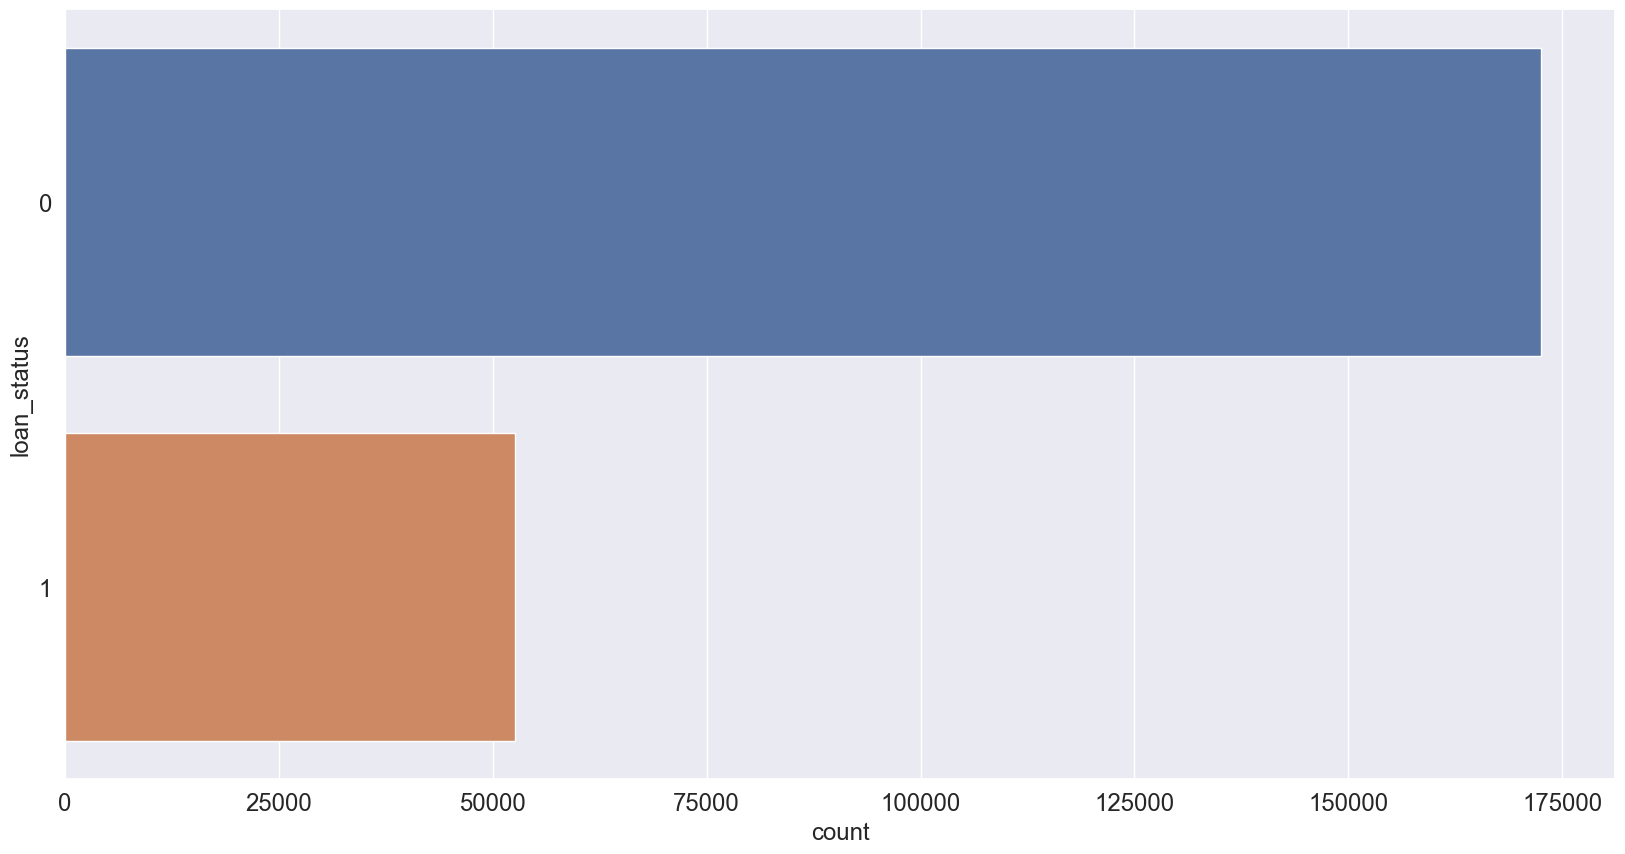

In [18]:
# Check for amount of defaults in the data using countplot
plt.figure()
sns.countplot(y="loan_status", data=df_processed)
plt.show()

### Numerical Features

In [19]:
from validmind.data_validation.metrics import TabularNumericalHistograms
metric = TabularNumericalHistograms(test_context)
metric.run()
metric.result.show()

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


### Categorical Features

In [20]:
from validmind.data_validation.metrics import TabularCategoricalBarPlots
metric = TabularCategoricalBarPlots(test_context)
metric.run()
metric.result.show()

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


### Datetime Features

In [21]:
from validmind.data_validation.metrics import TabularDateTimeHistograms
metric = TabularDateTimeHistograms(test_context)
metric.run()
metric.result.show()

### Loan Defaults by Categorical Variable

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_loan_default_ratio(data, loan_status_col, columns=None, rsorted=True):
    # Use all features if columns is not specified, else use selected columns
    features = data.columns if columns is None else columns

    for feature in features:
        fig, axs = plt.subplots(1, 2)
        
        # Create sorted unique list of feature values for both plots
        feature_dimension = sorted(data[feature].unique()) if rsorted else data[feature].unique()
        
        # First subplot for univariate count
        count_values = [data[data[feature]==fd][loan_status_col].count() for fd in feature_dimension]
        axs[0].bar(feature_dimension, count_values, color='#6699cc')
        axs[0].set_title(f"{feature}", fontsize=18)
        axs[0].set_ylabel("Count", fontsize=18)
        
        # Second subplot for univariate ratio
        # We don't use 'barplot' since it automatically sorts the categories on the x-axis 
        # in order of appearance in the data
        ratio_values = [data[data[feature]==fd][loan_status_col].mean() for fd in feature_dimension]
        axs[1].bar(feature_dimension, ratio_values, color='orange')
        axs[1].set_title(f"{feature}", fontsize=18)
        axs[1].set_ylabel("Loan Defaults Ratio", fontsize=18)
        
        plt.tight_layout()
        plt.show()


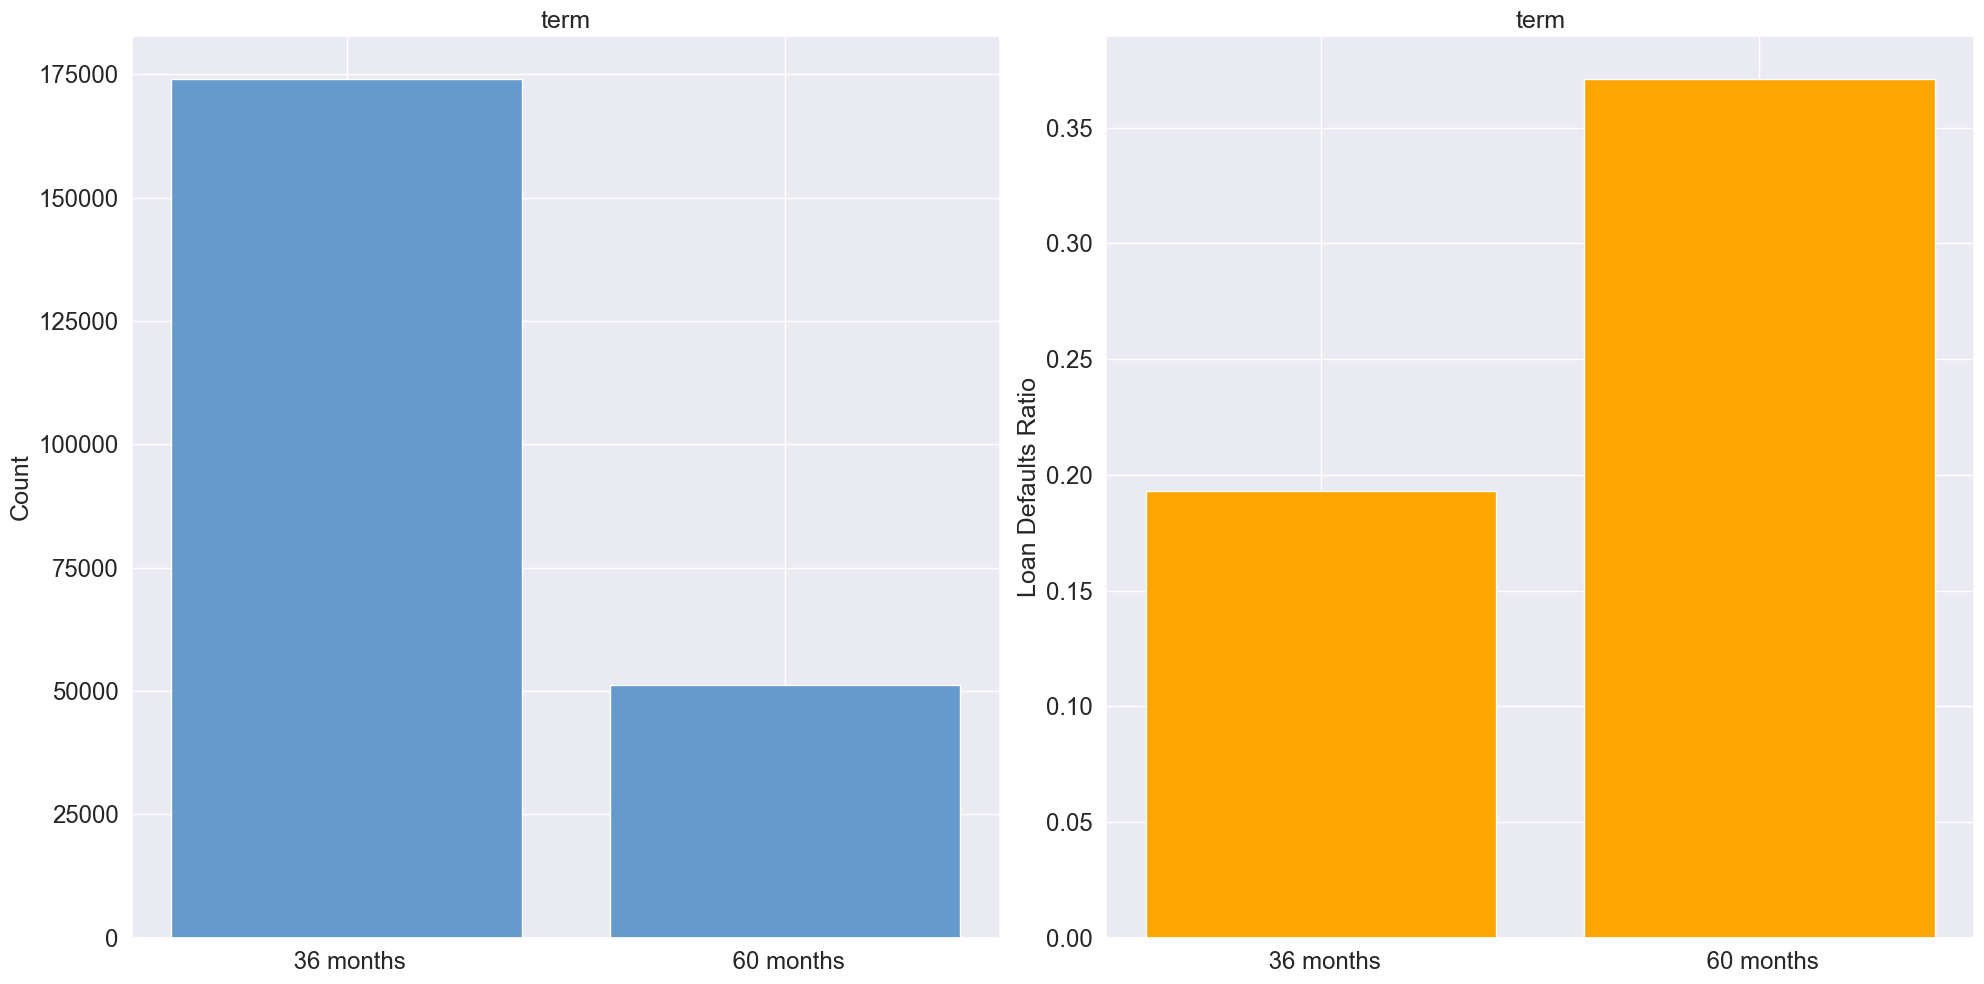

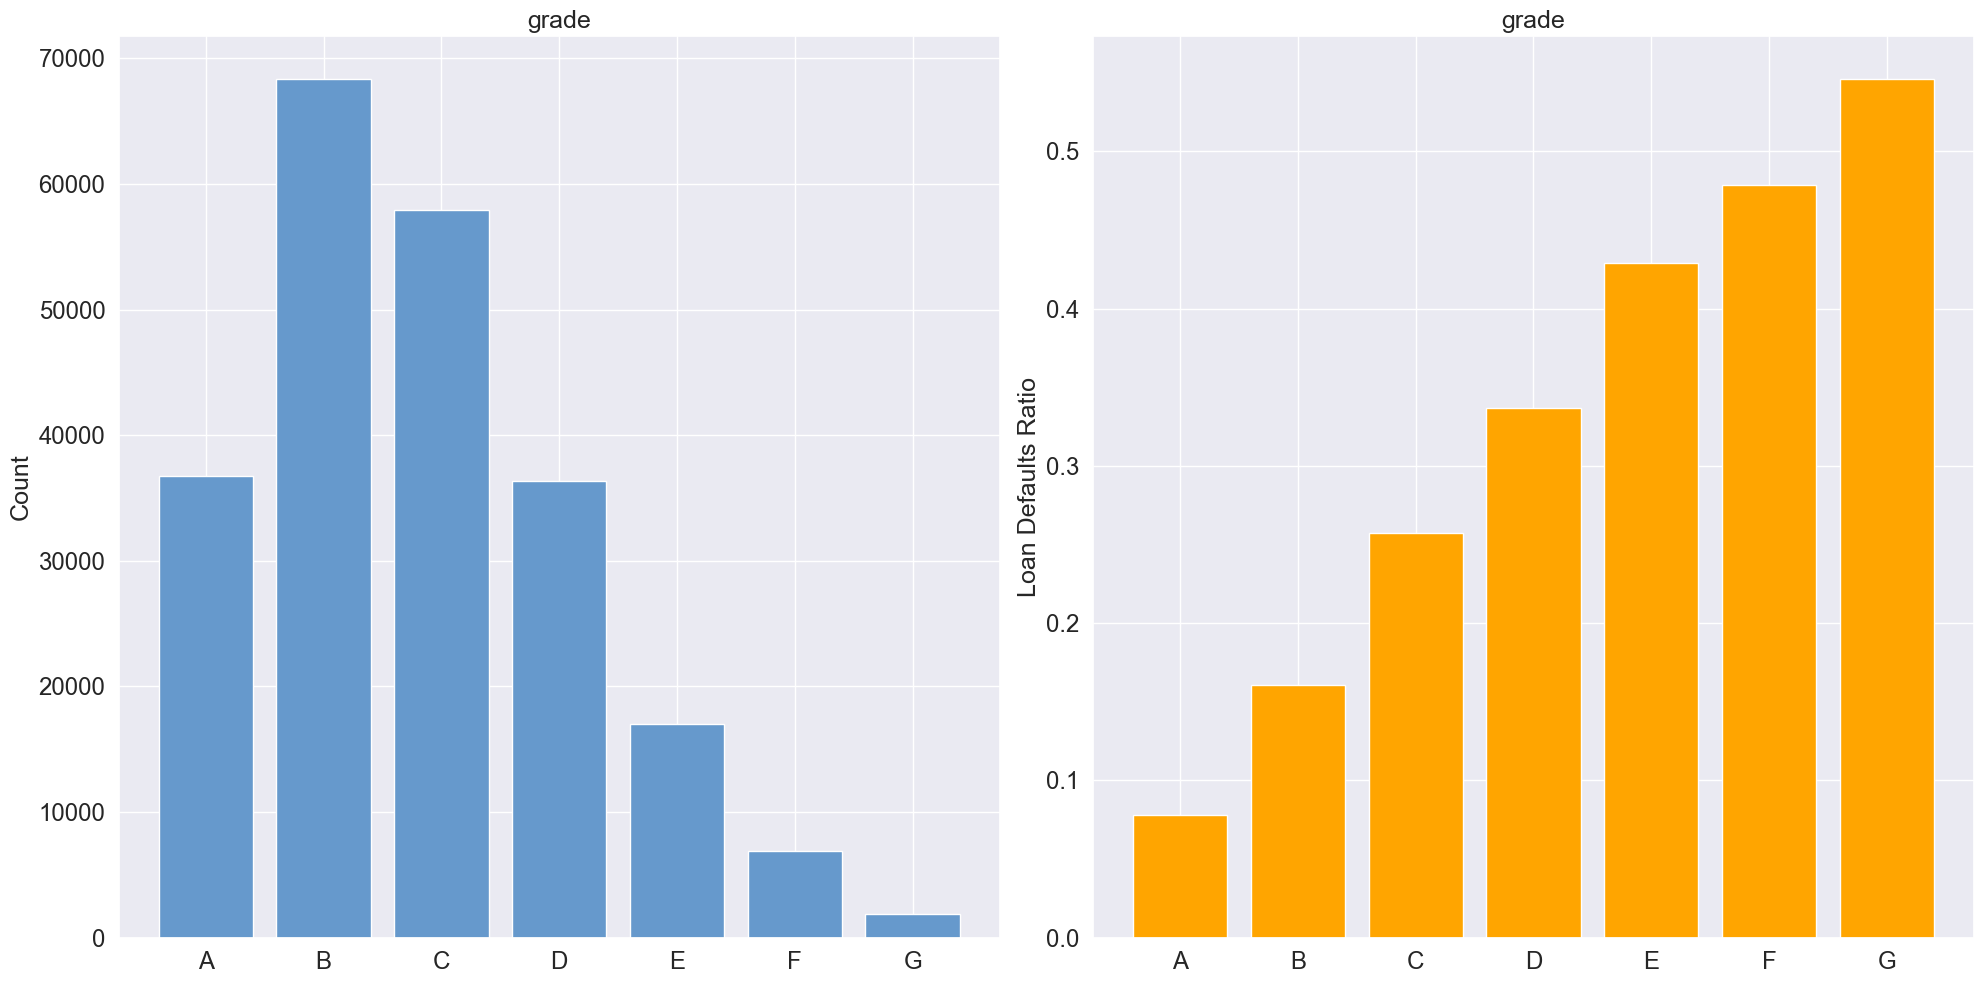

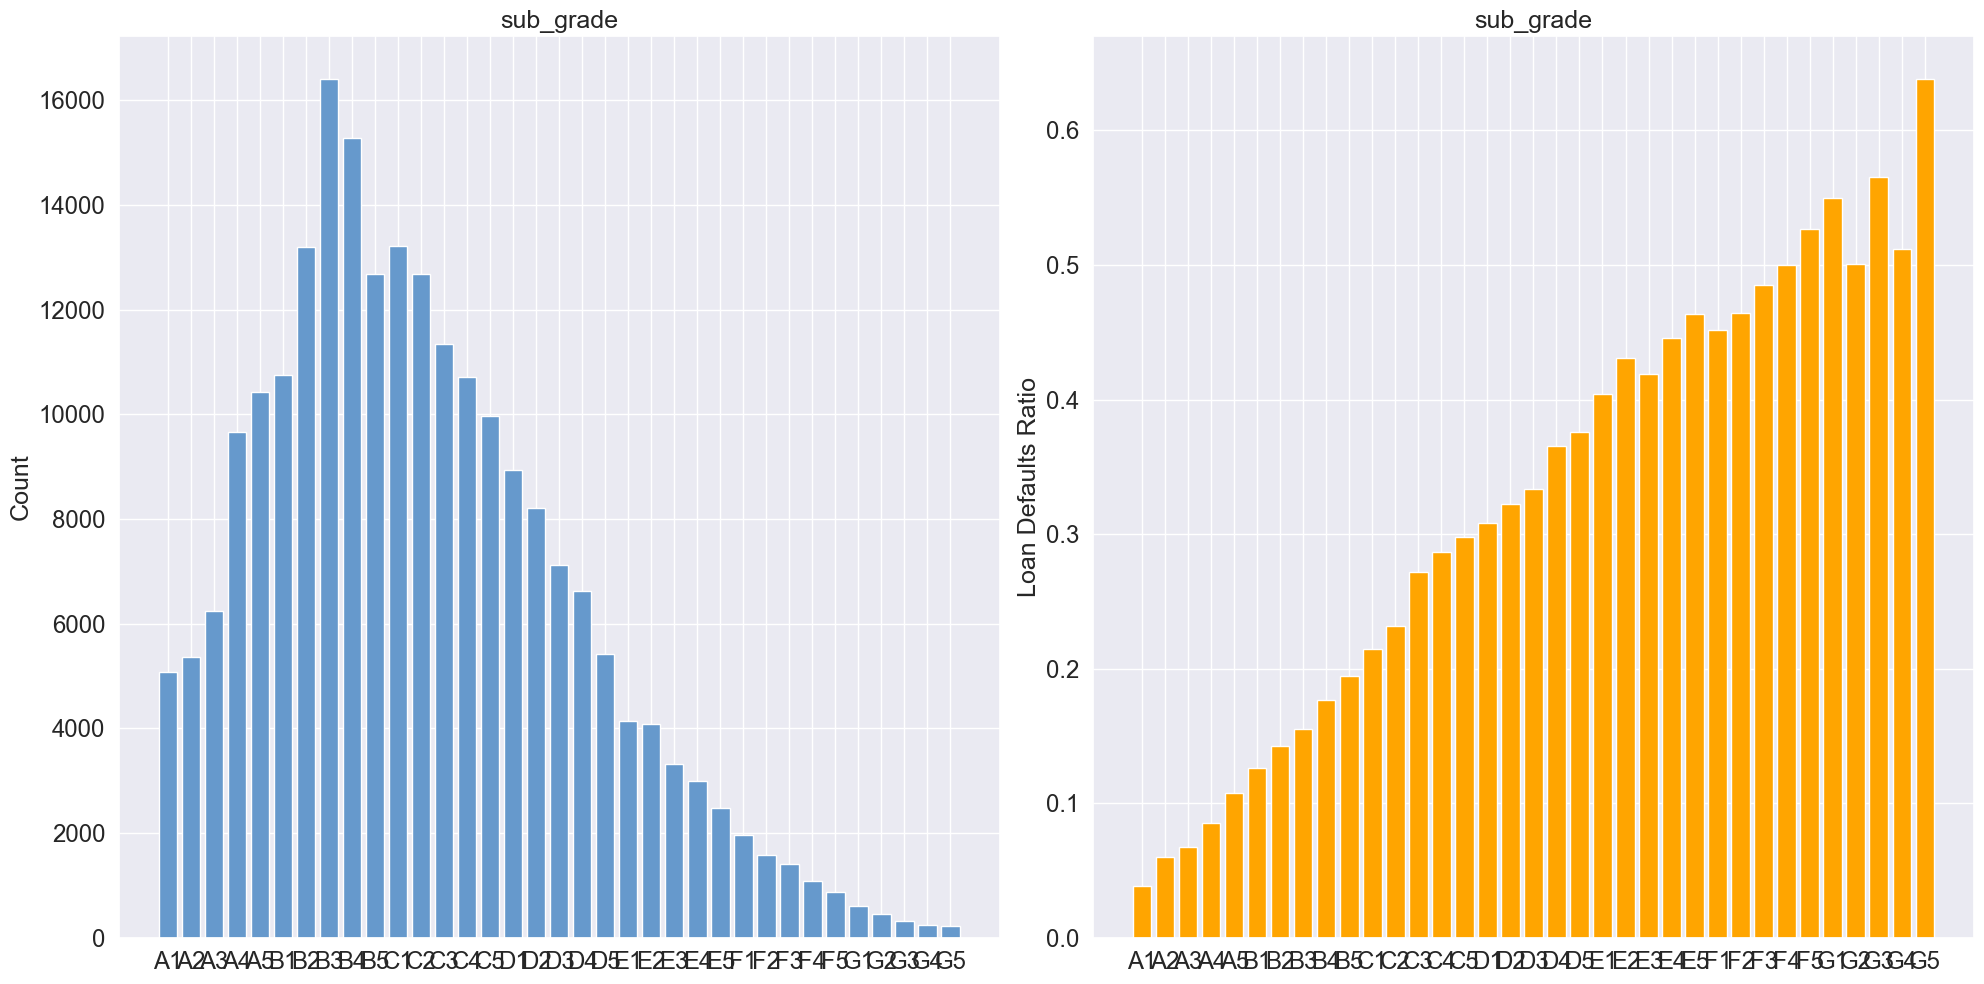

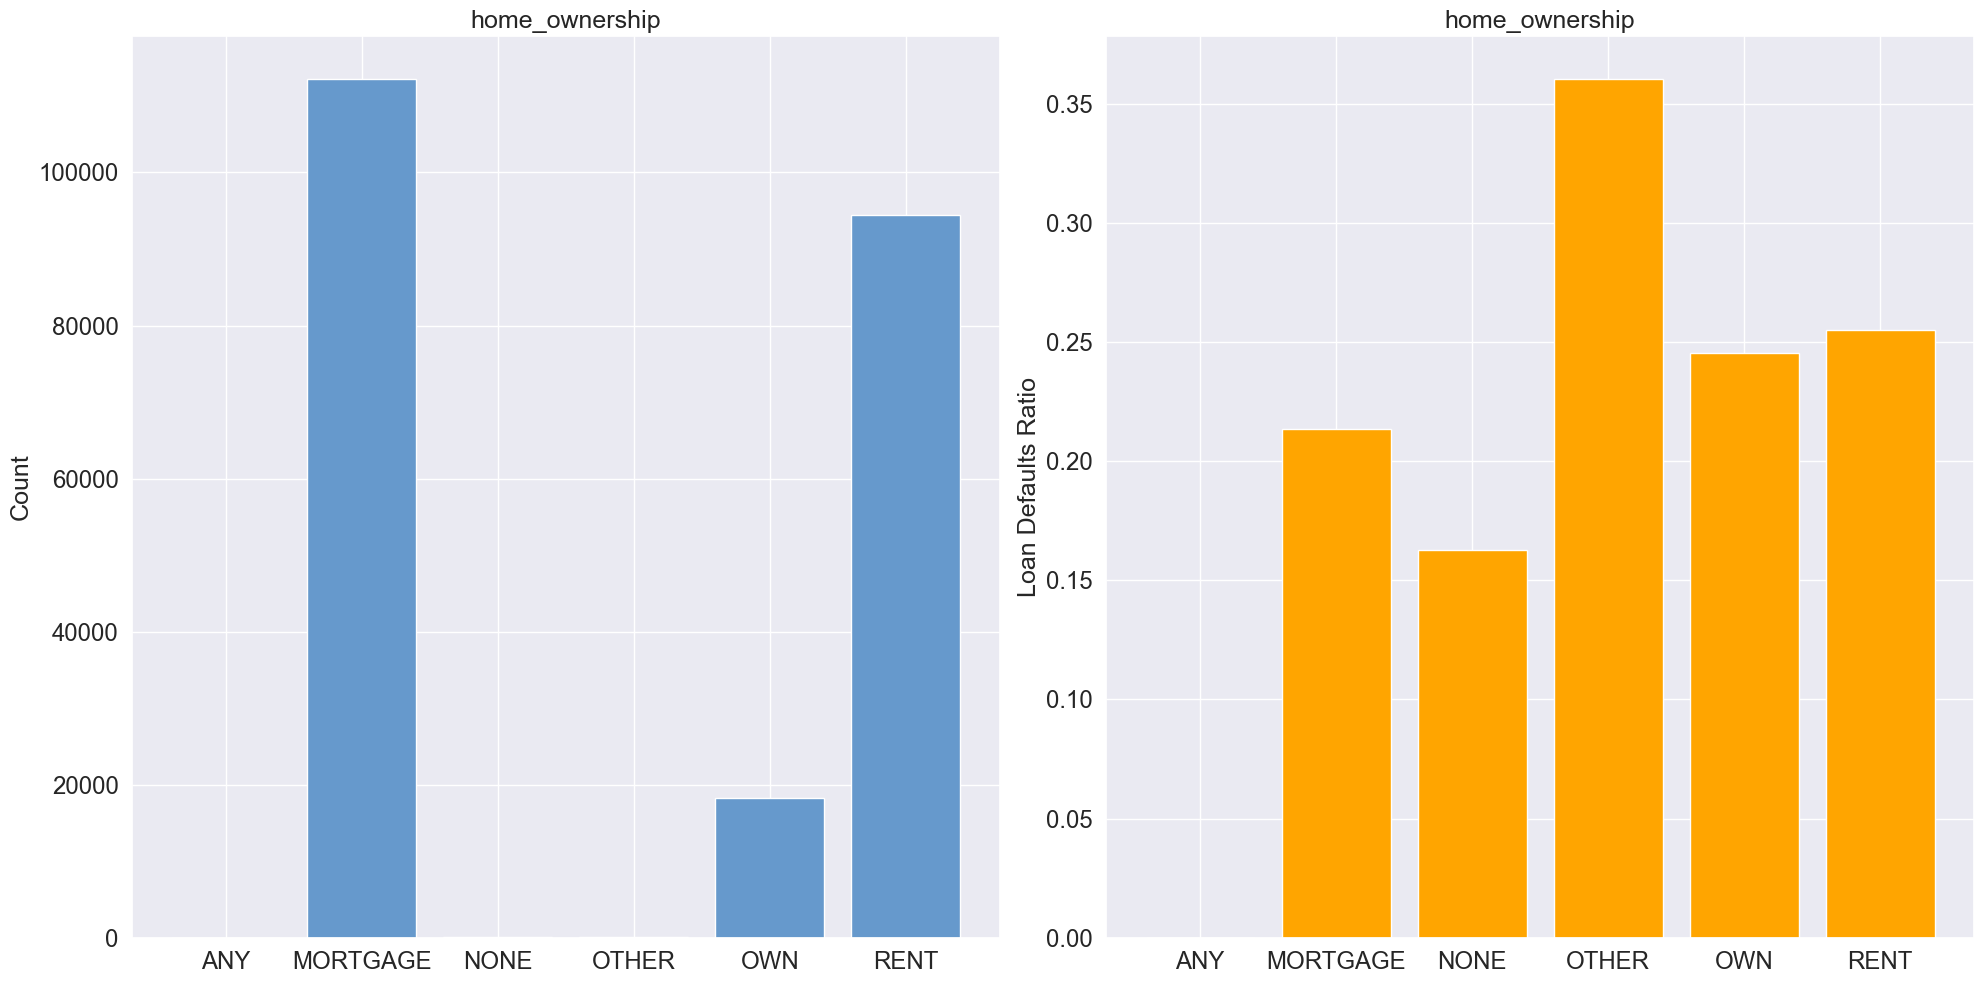

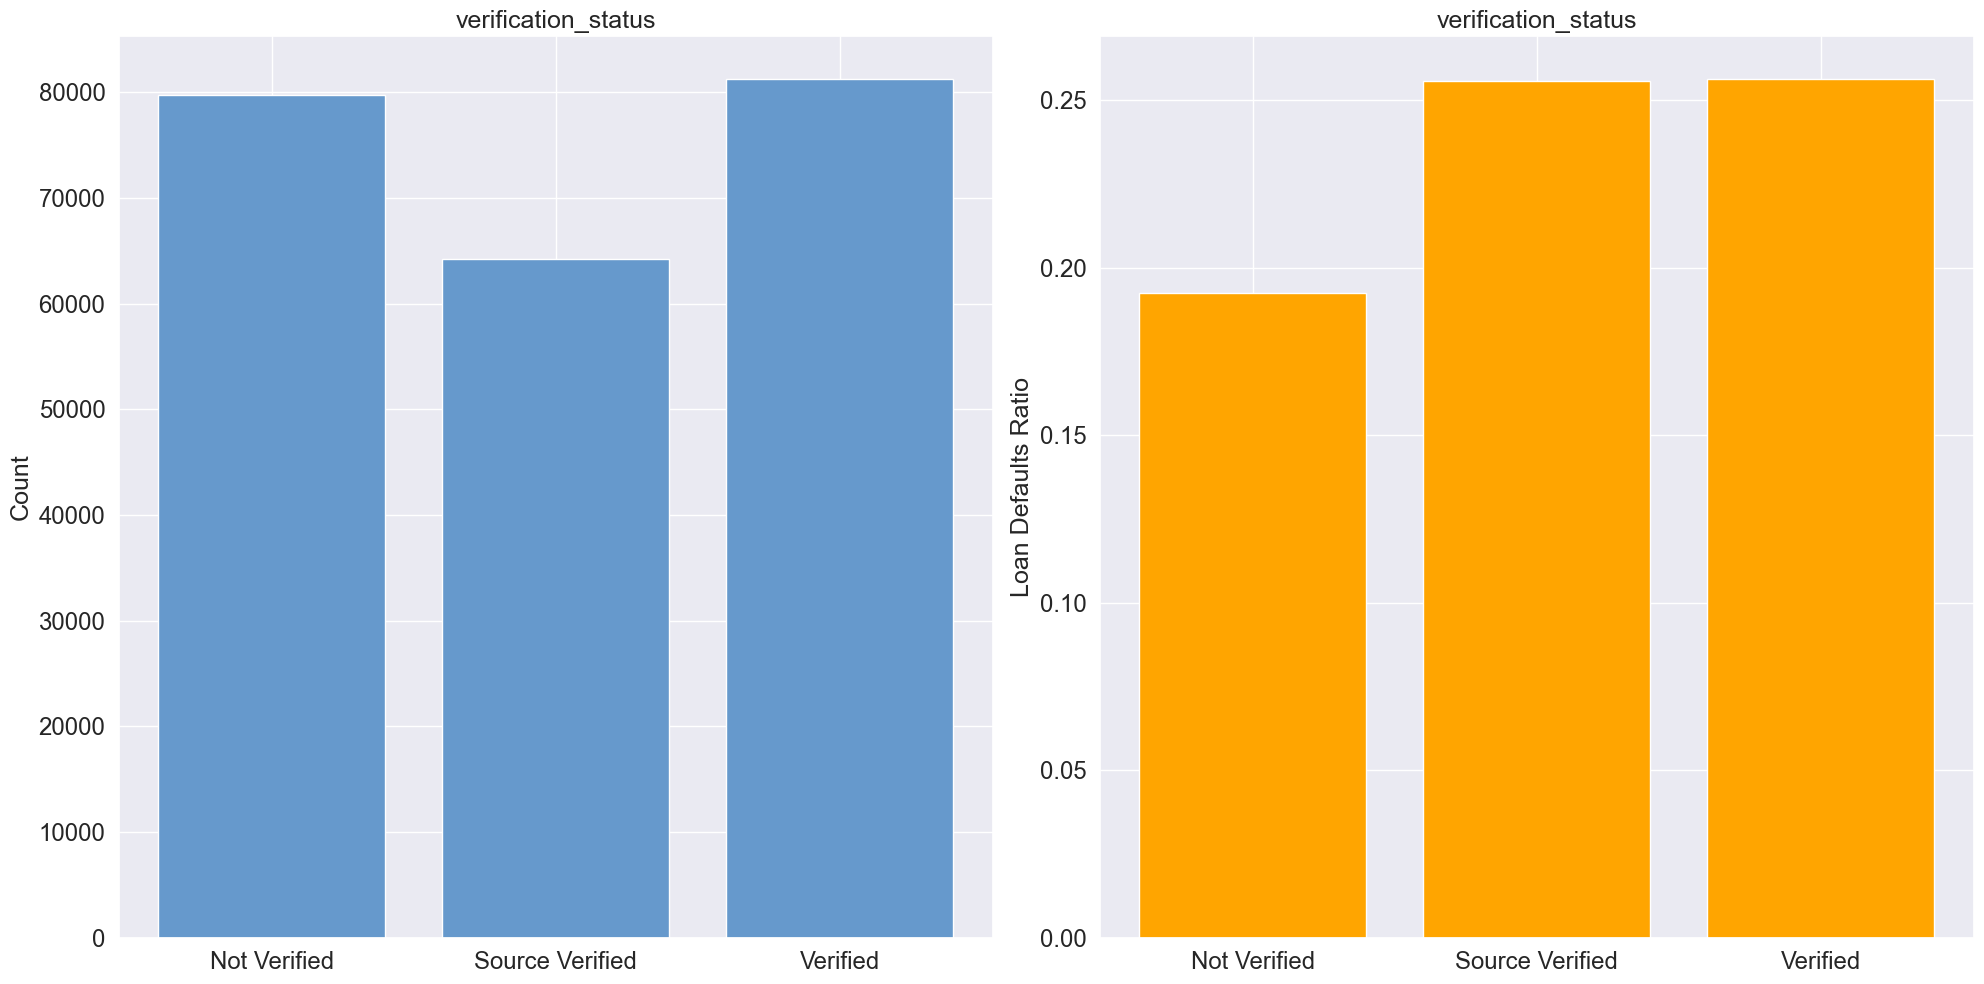

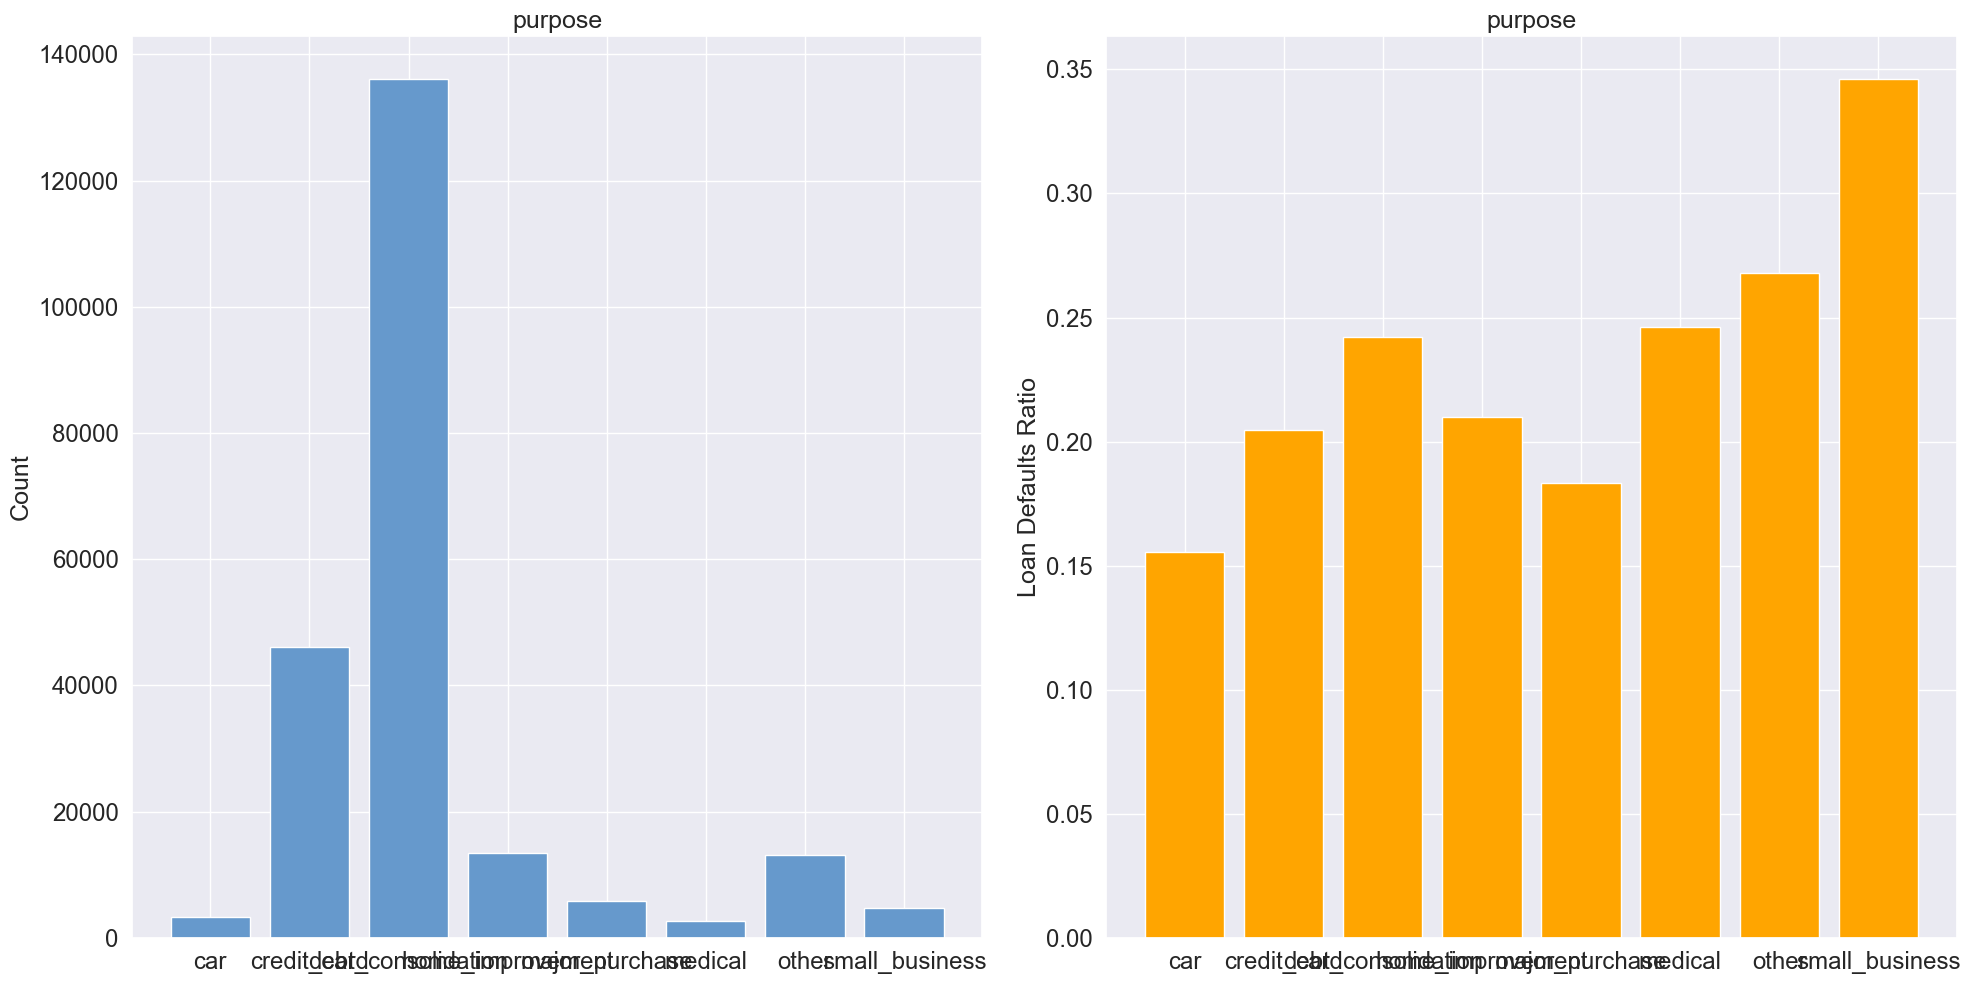

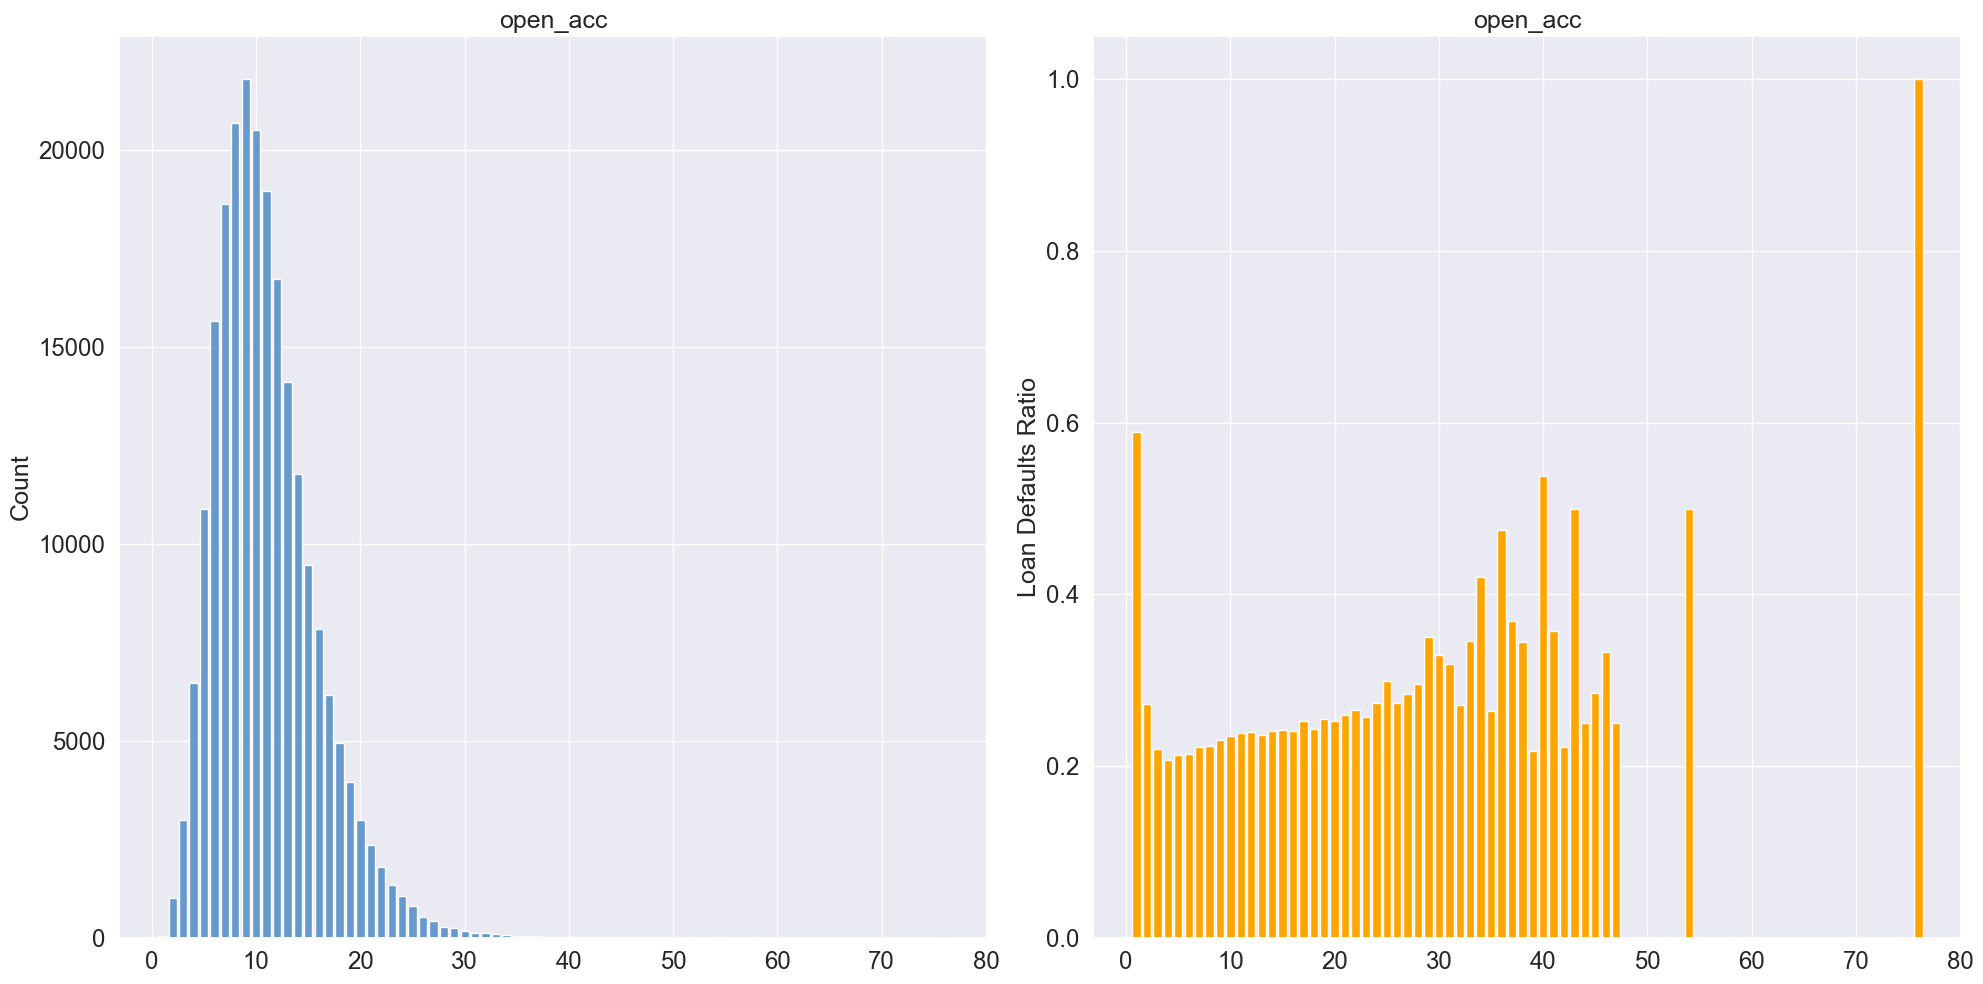

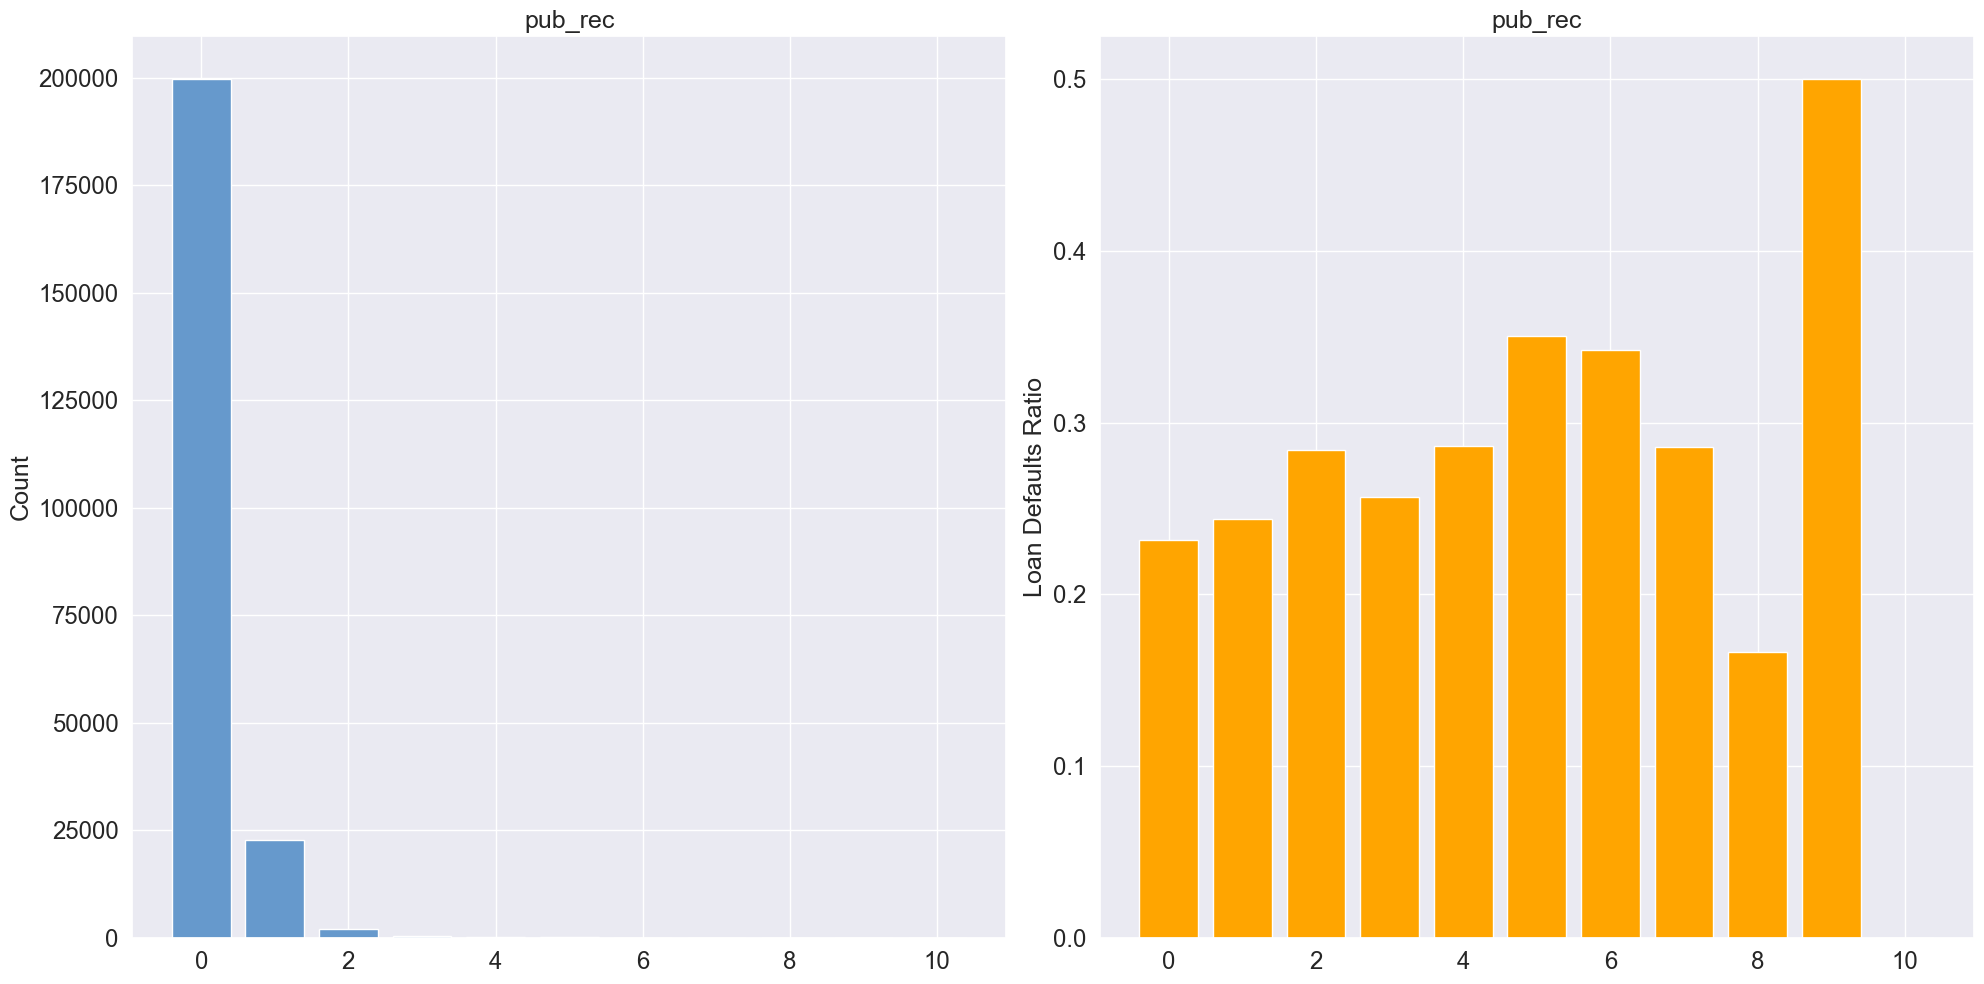

In [23]:
categorical_variables = ['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'open_acc', 'pub_rec']
plot_loan_default_ratio(df_processed, loan_status_col='loan_status', columns=categorical_variables)

### Loan Defaults by Numerical Variable

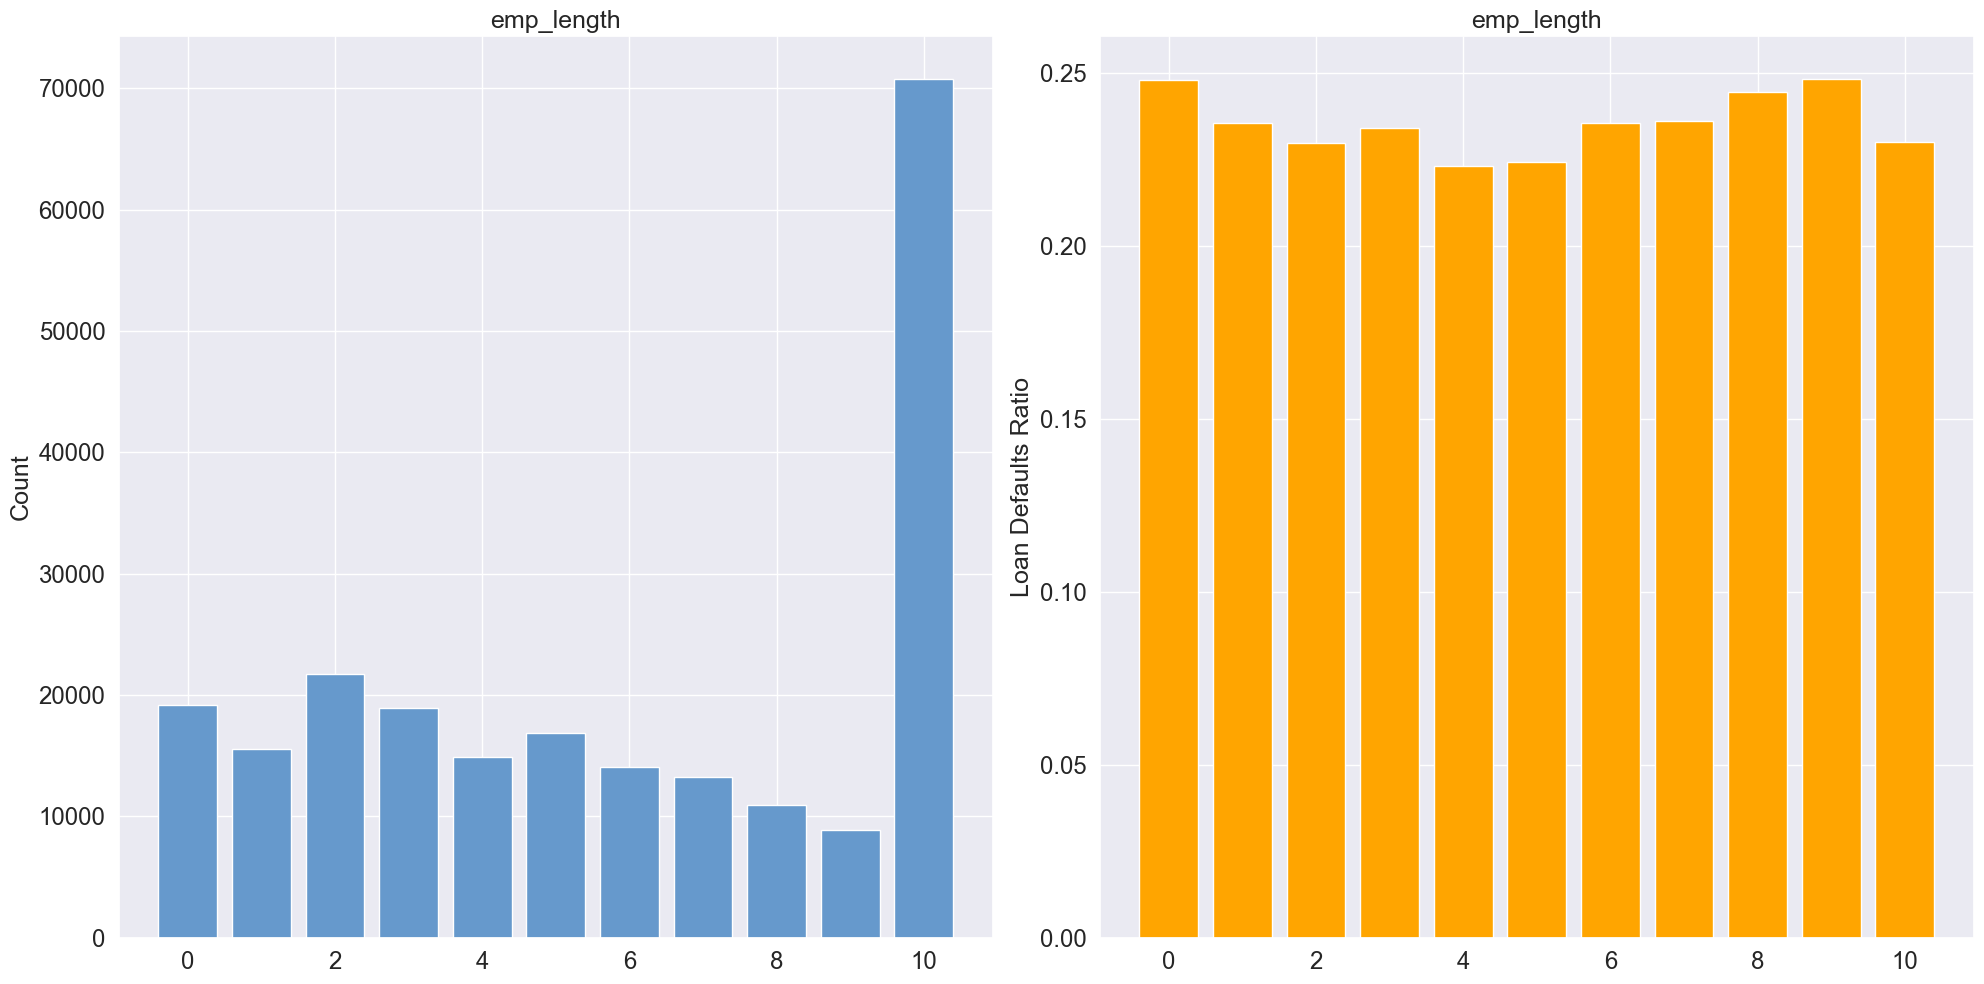

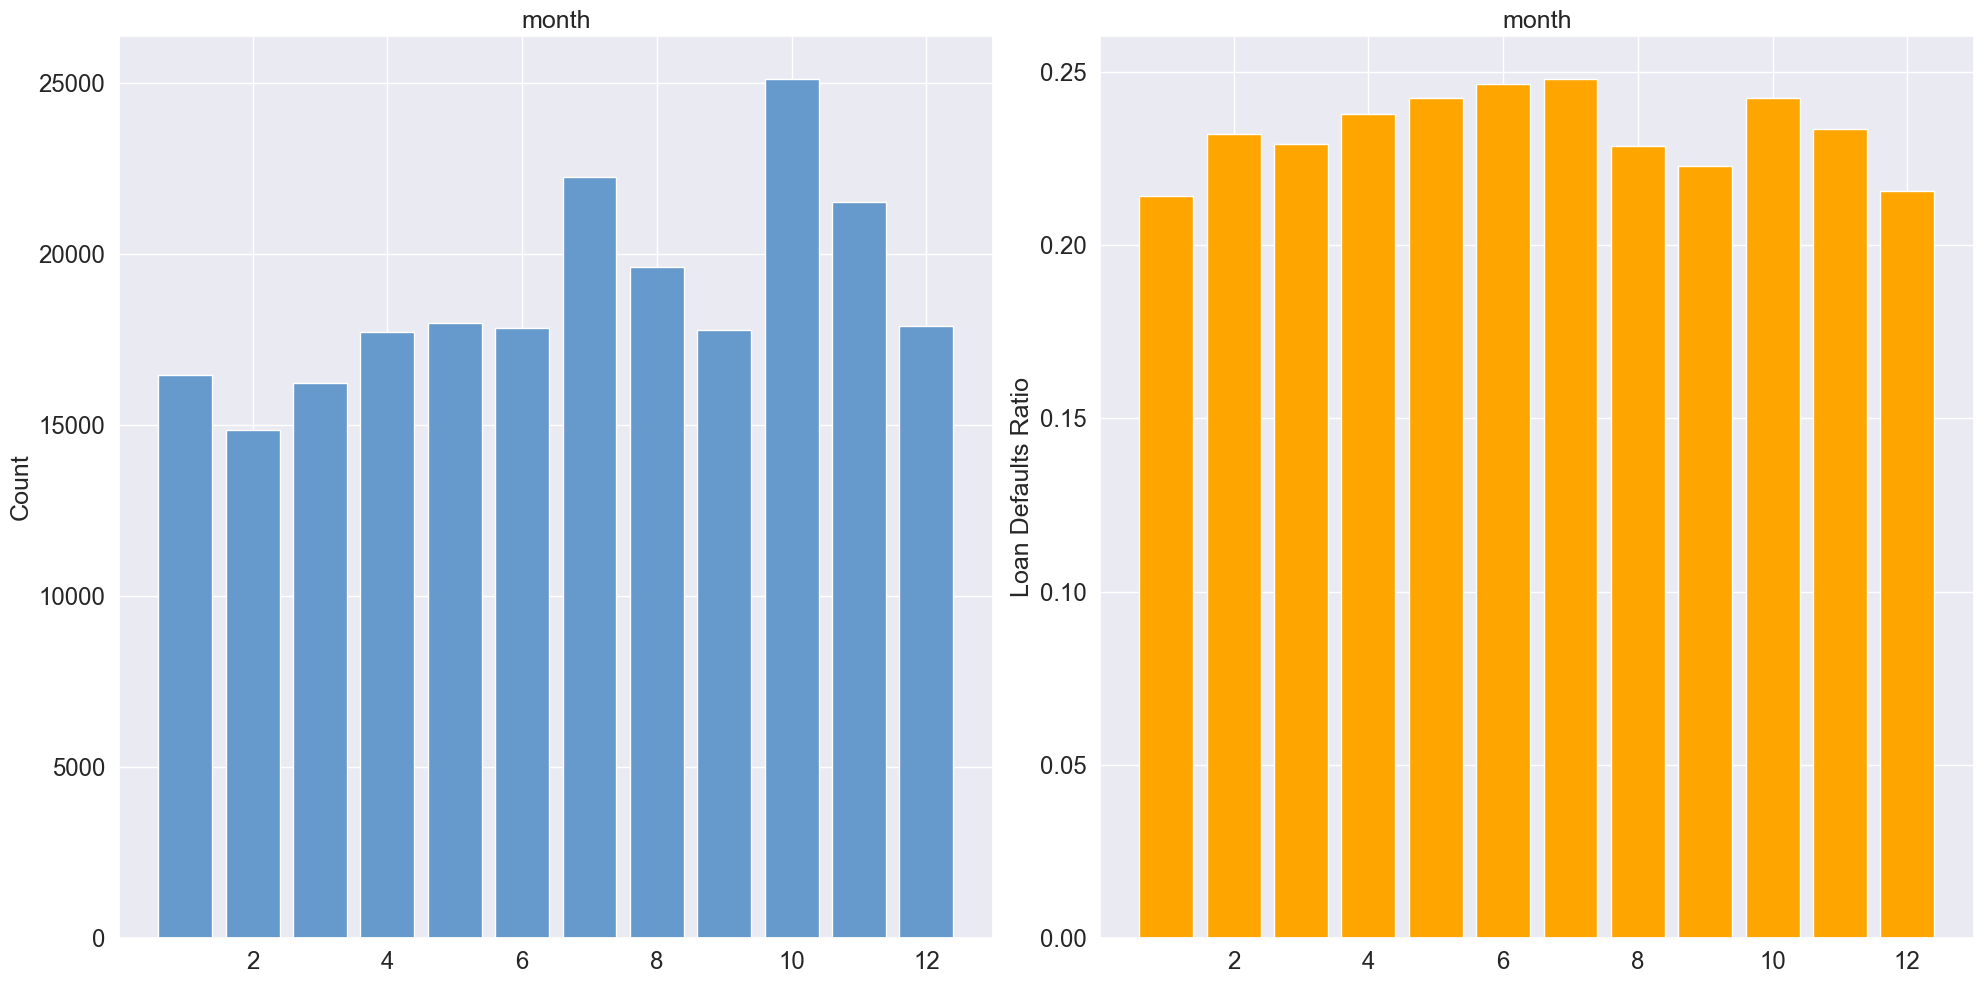

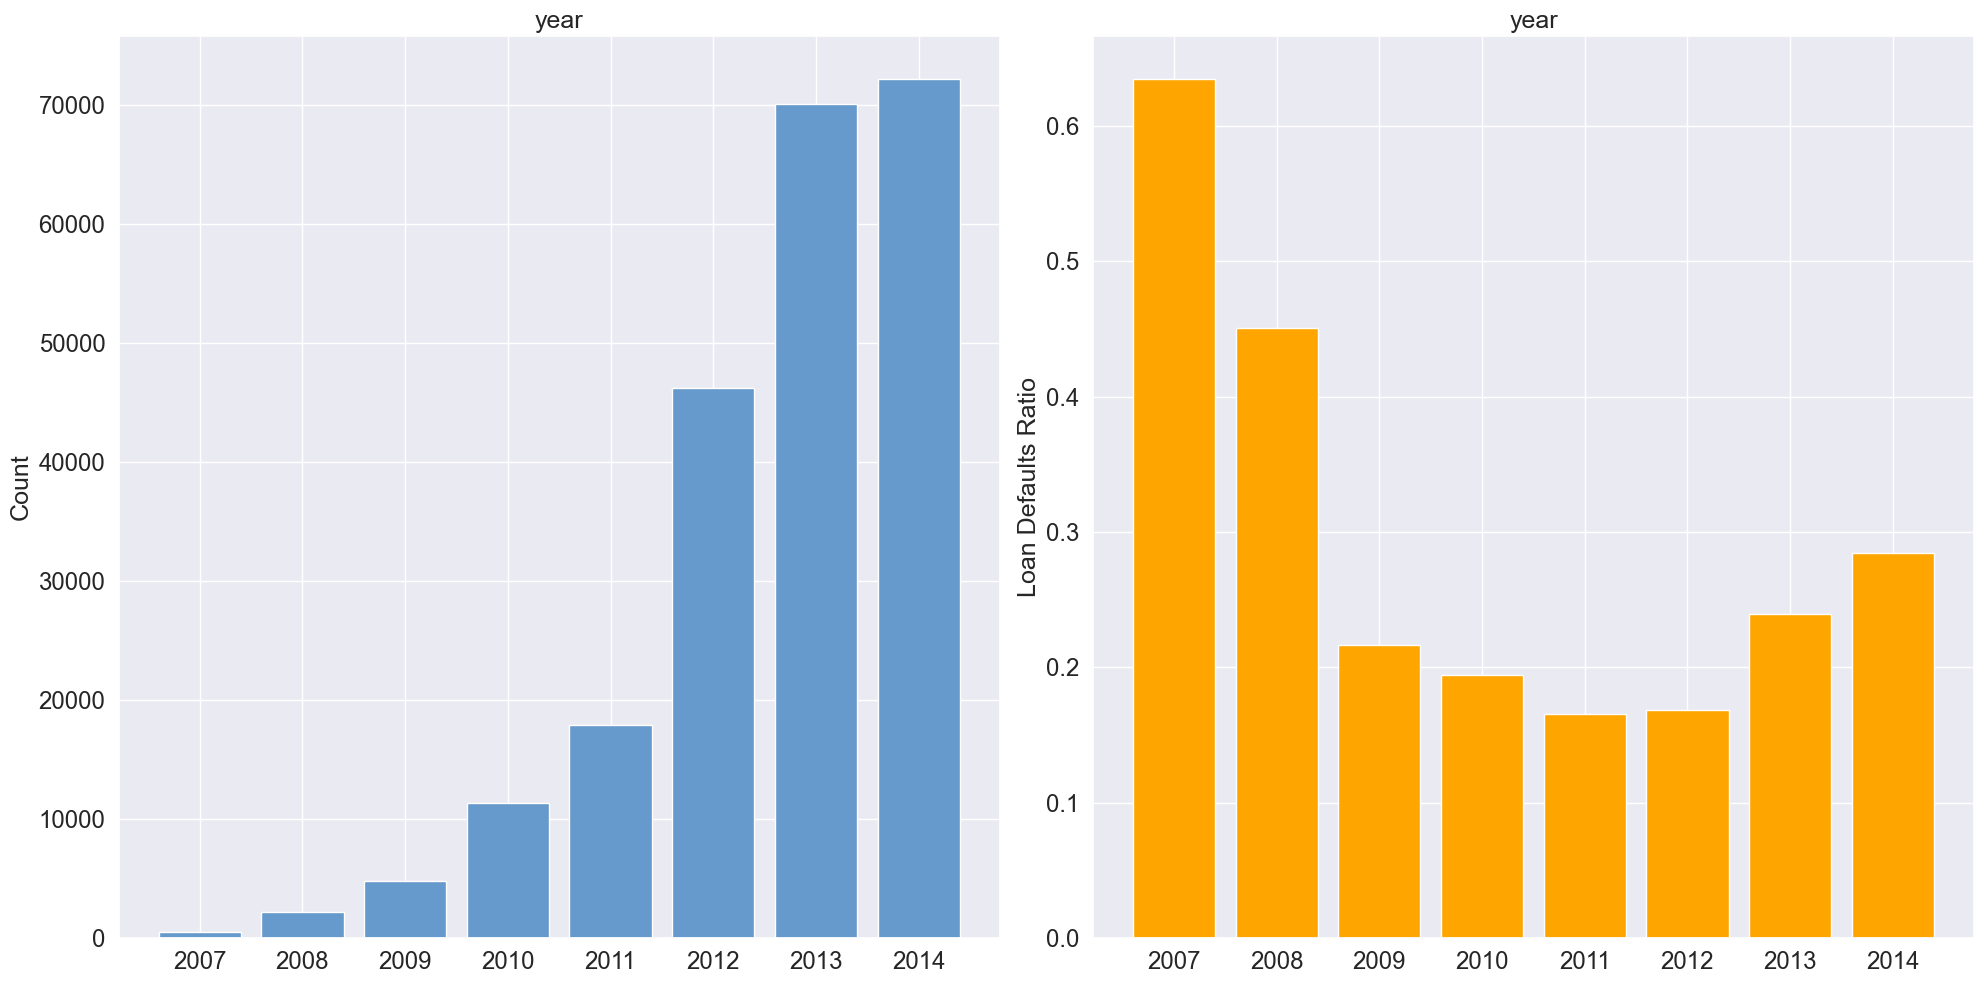

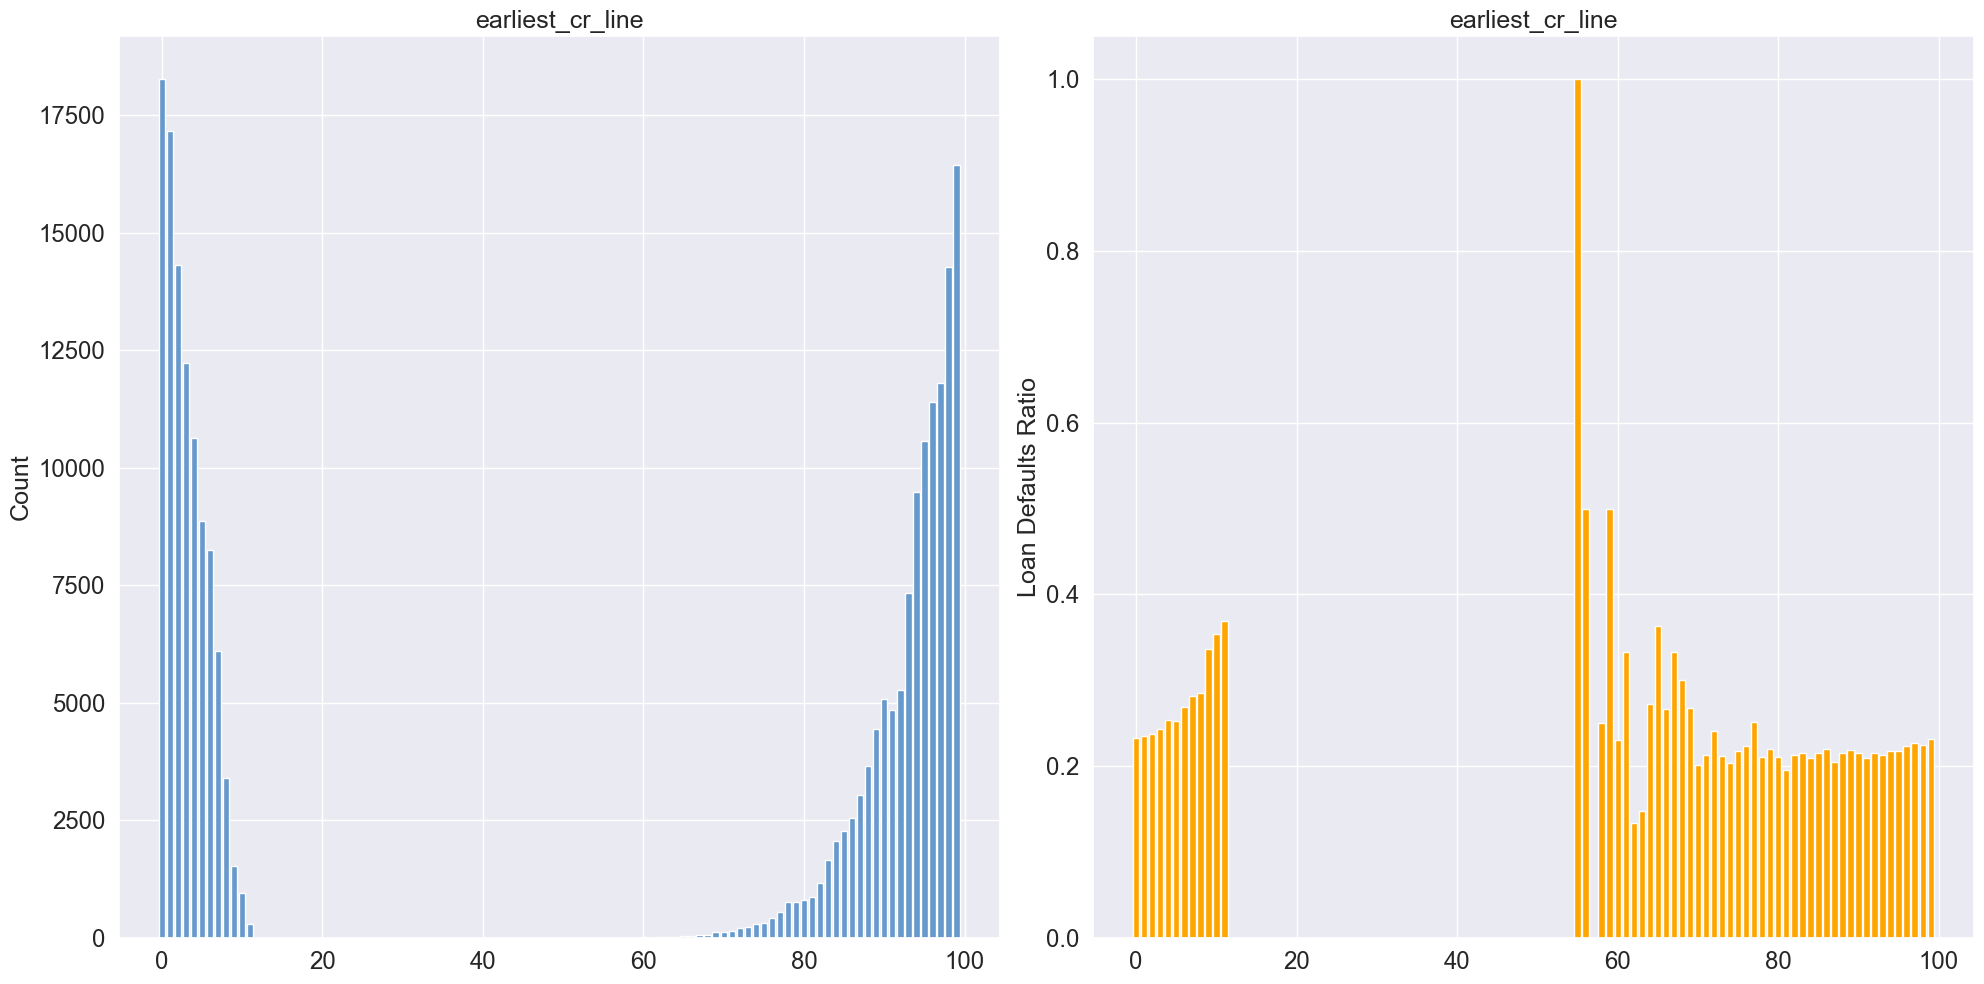

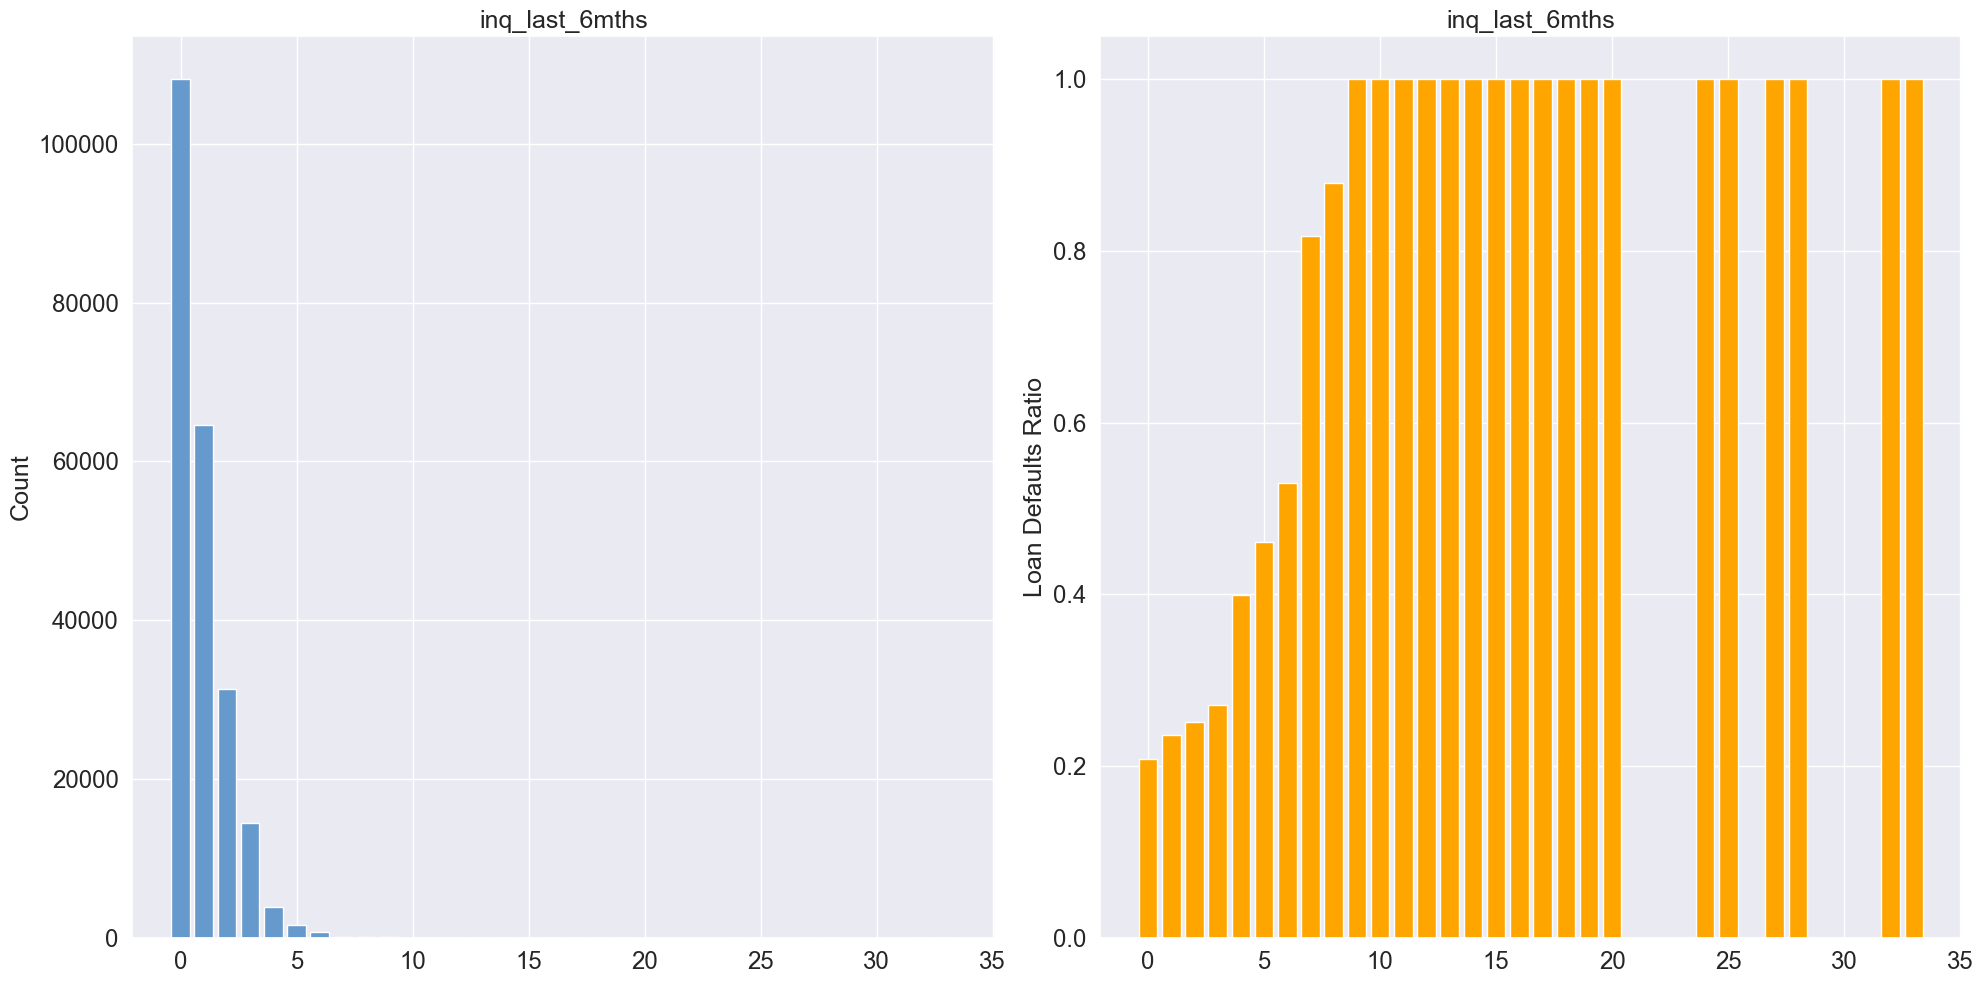

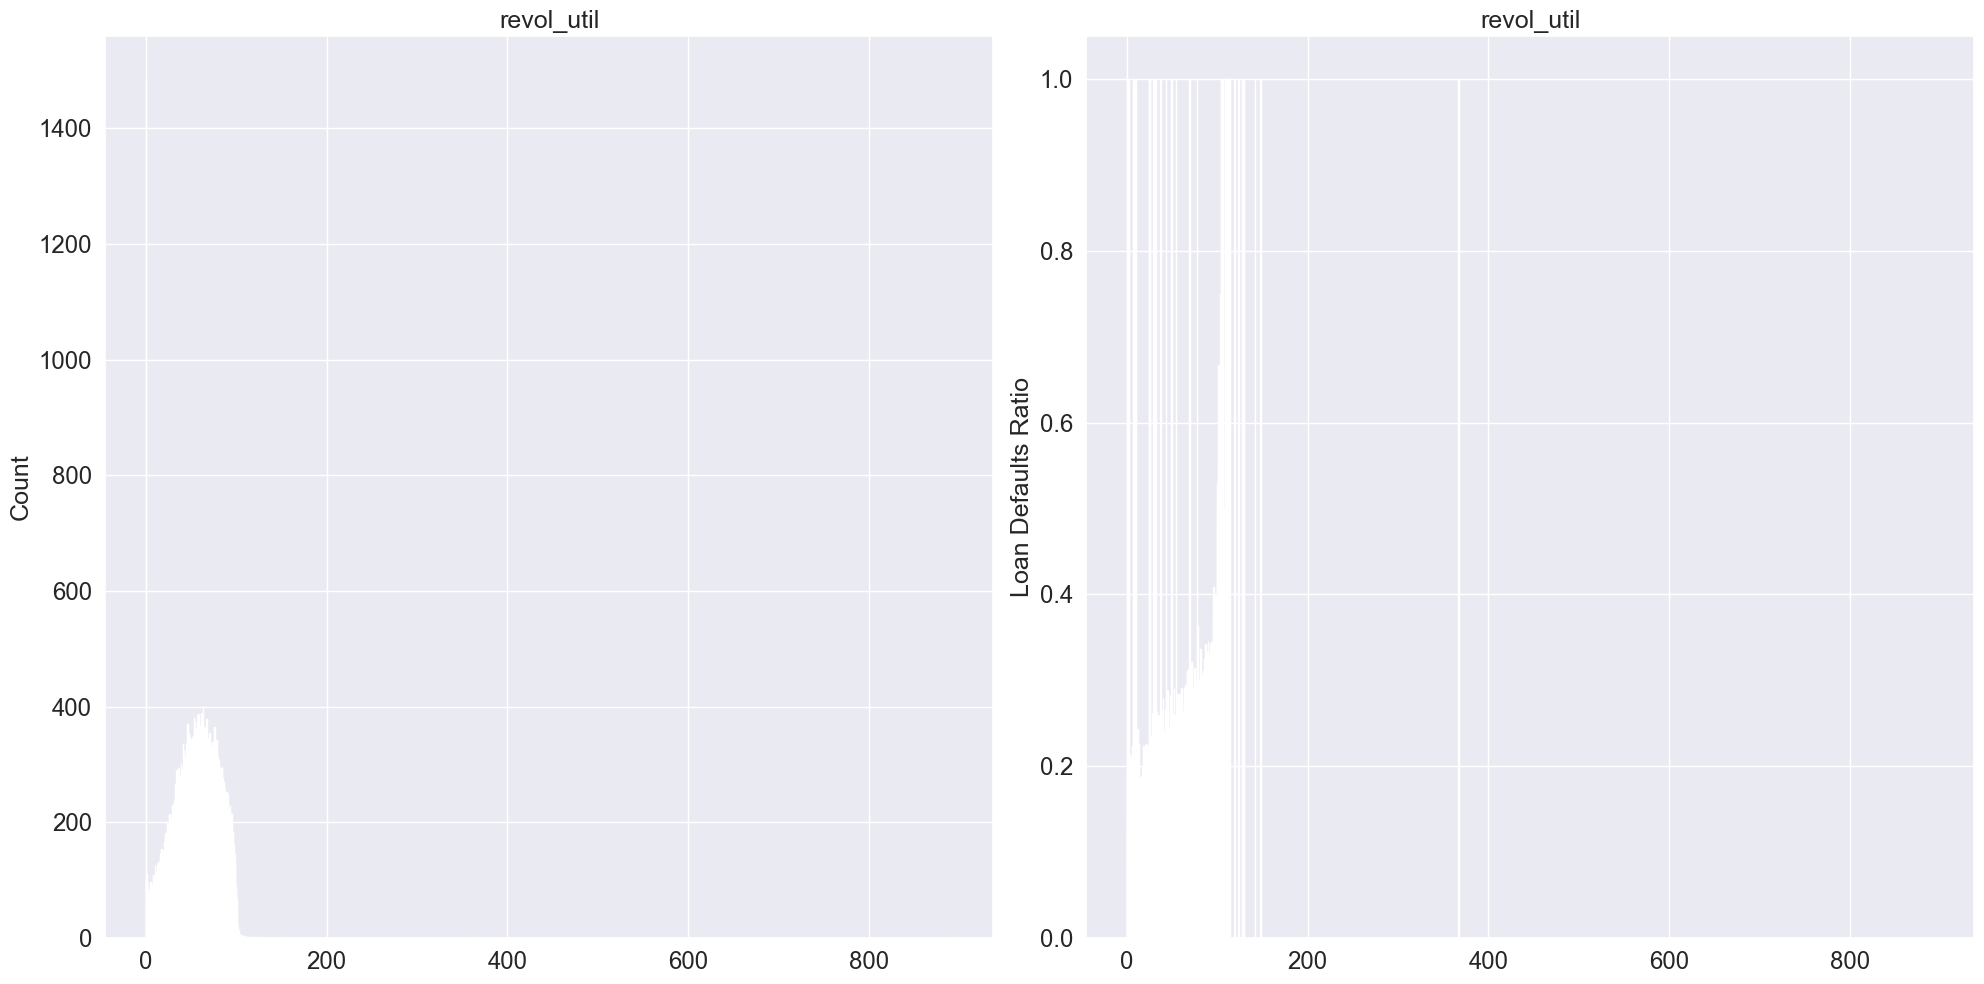

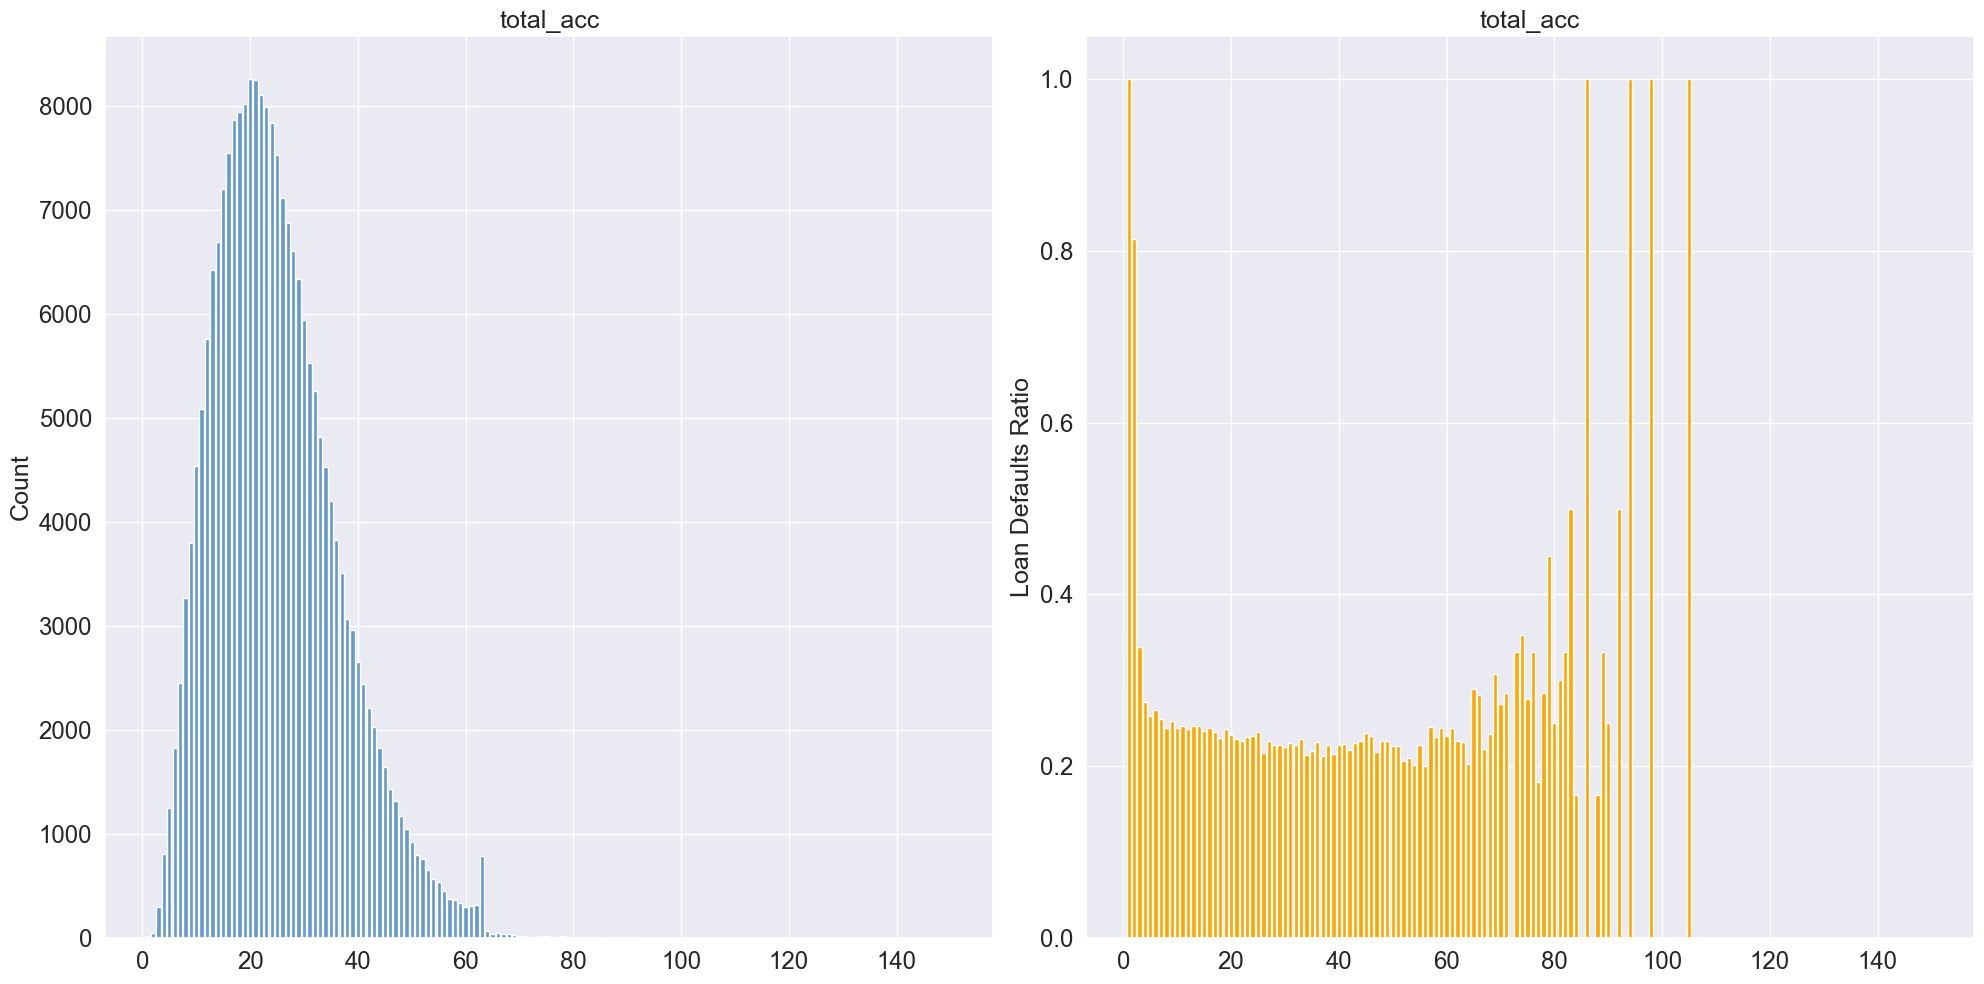

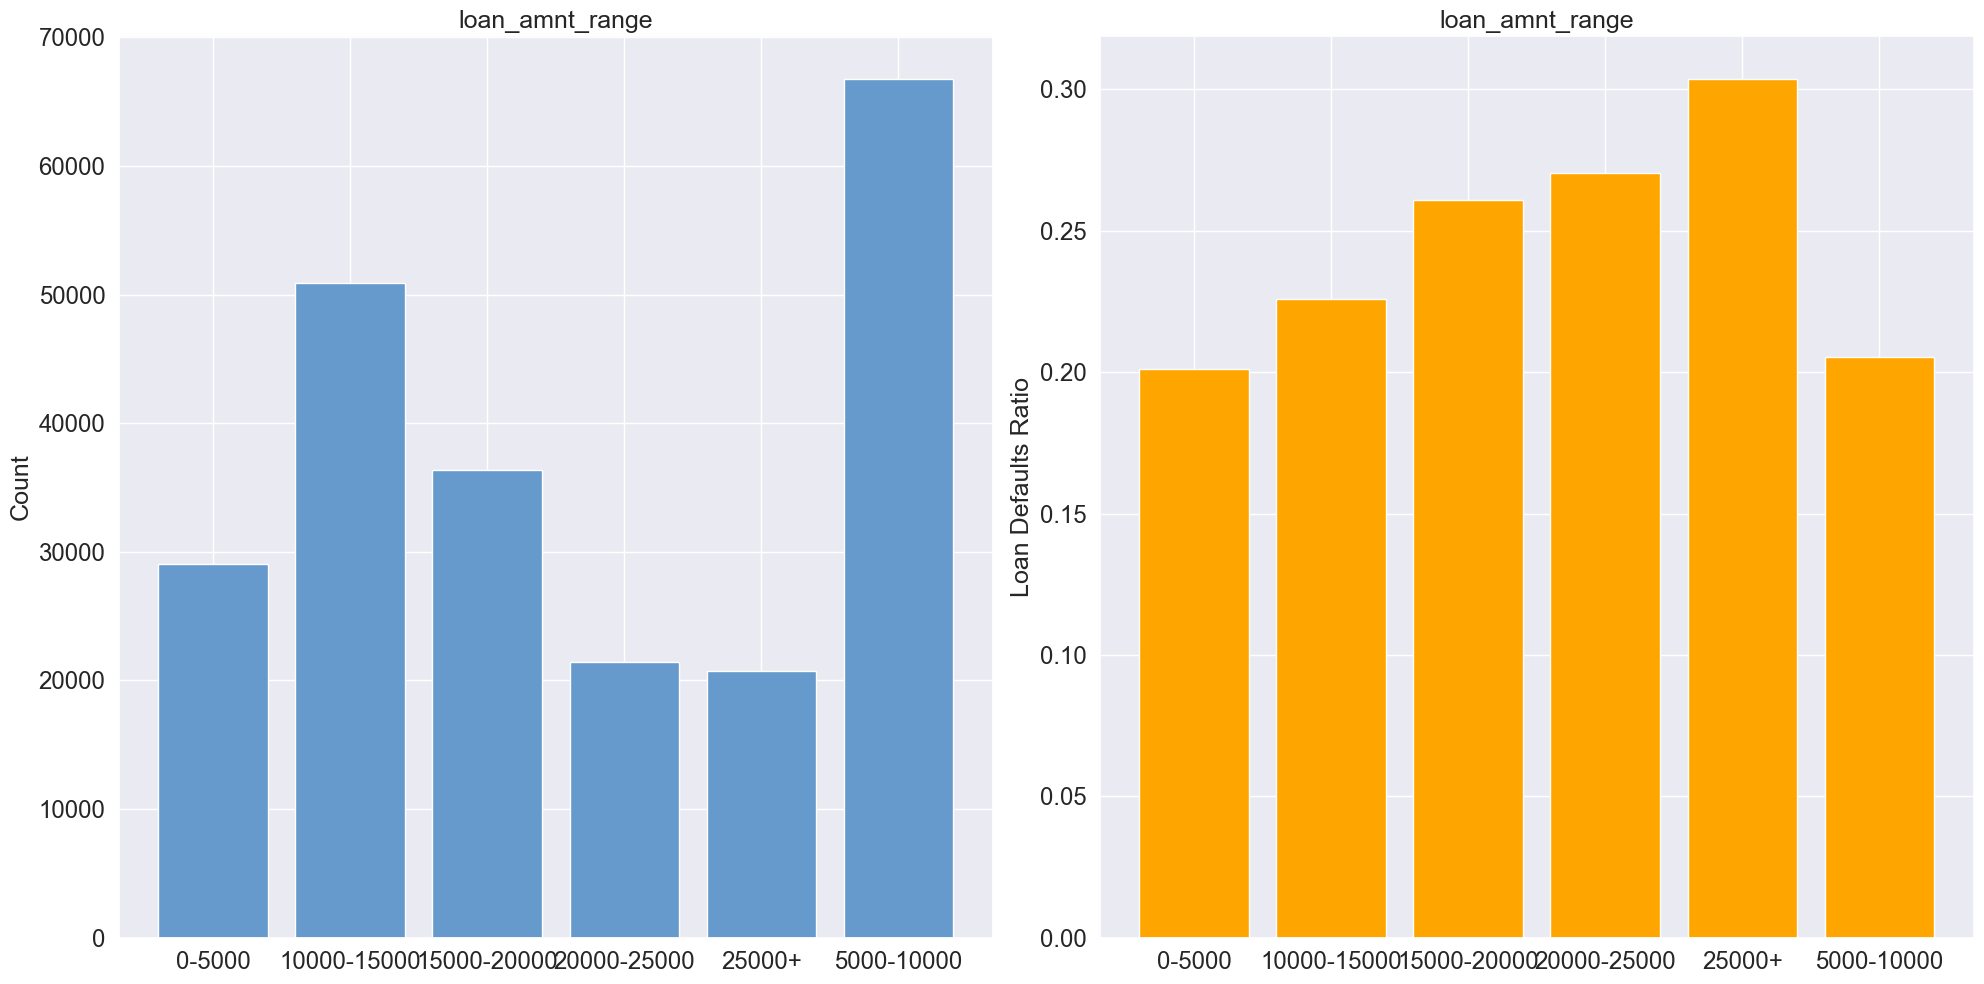

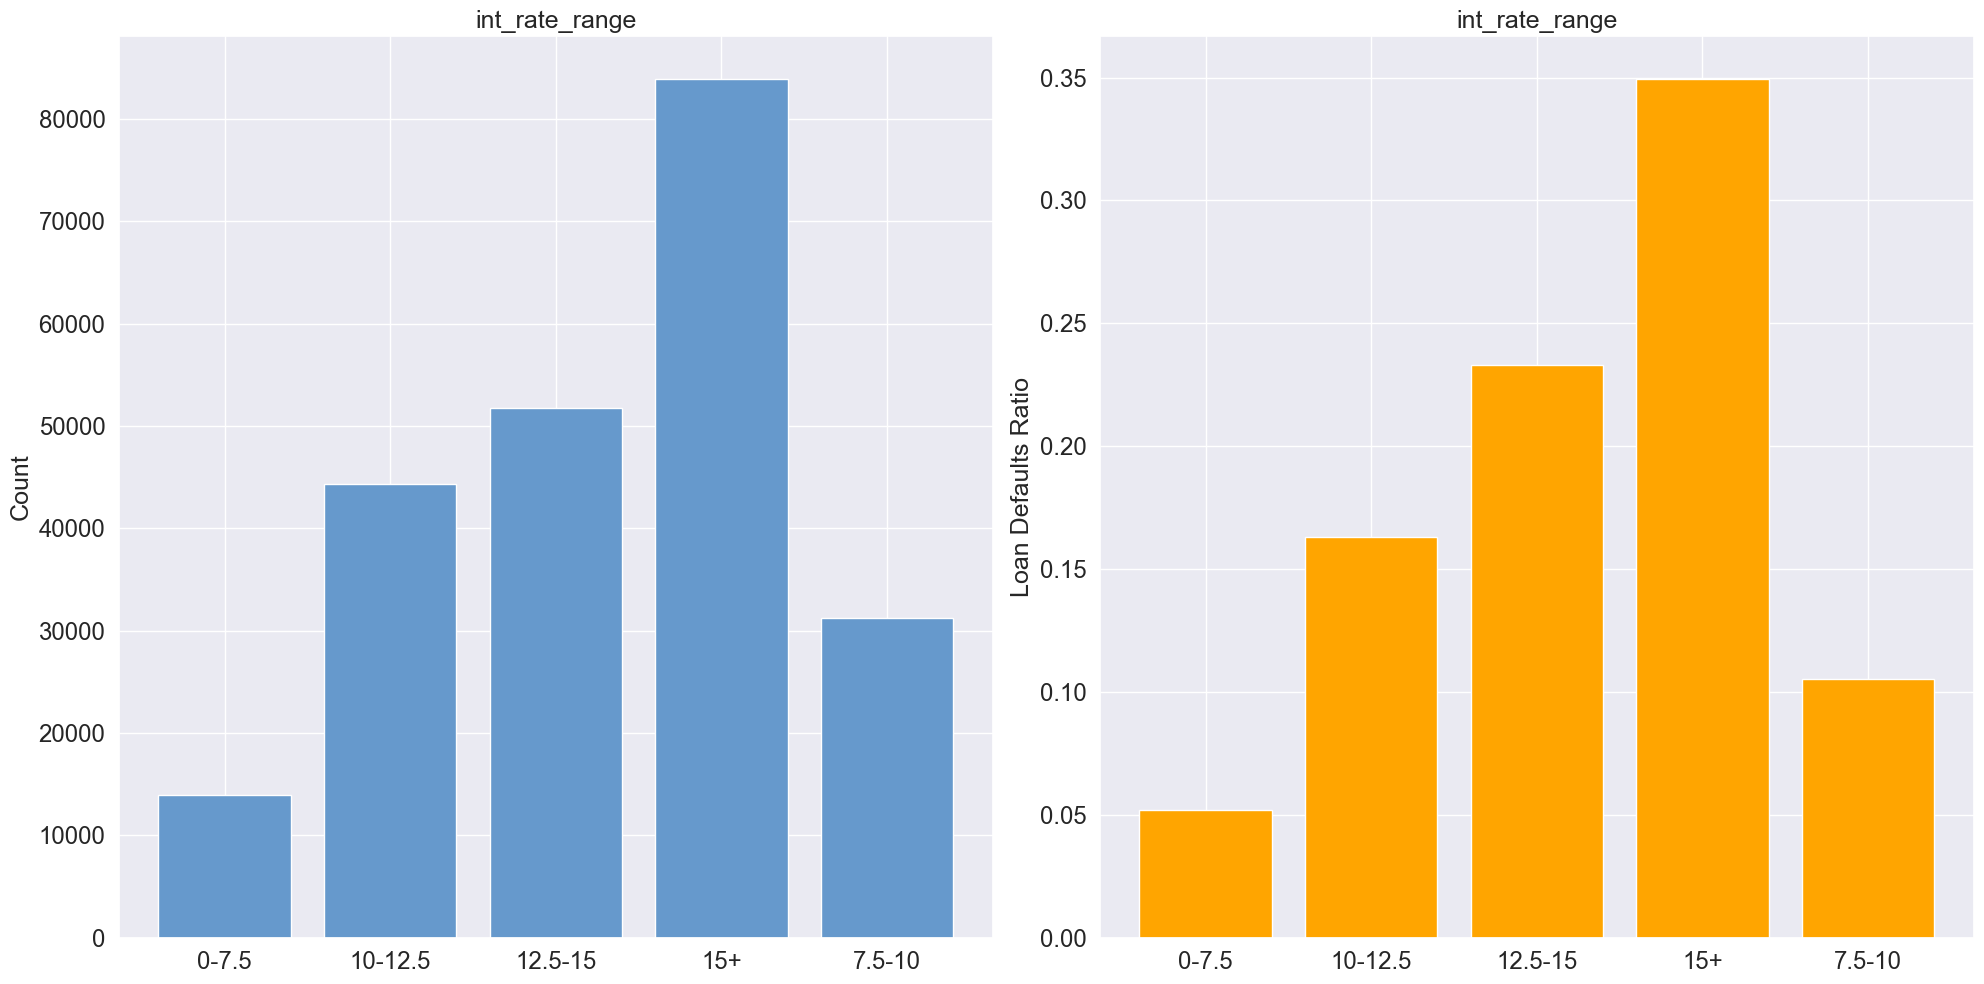

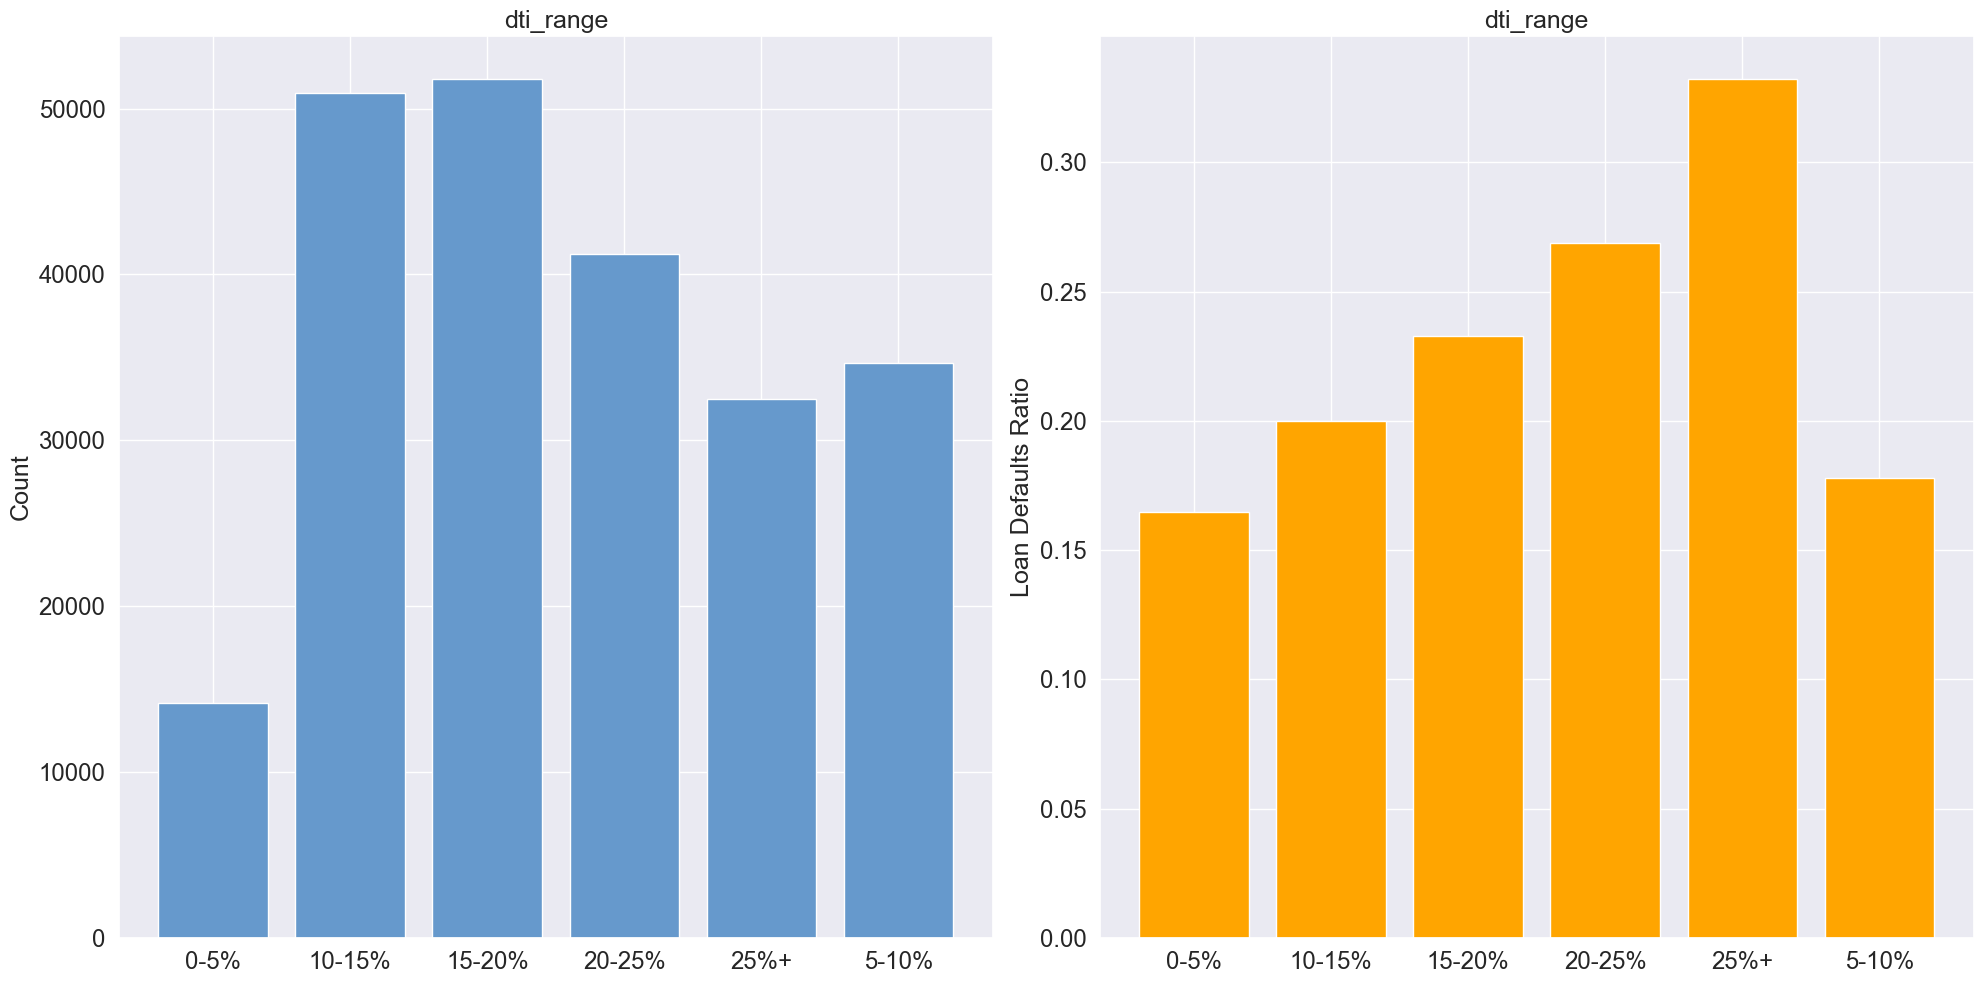

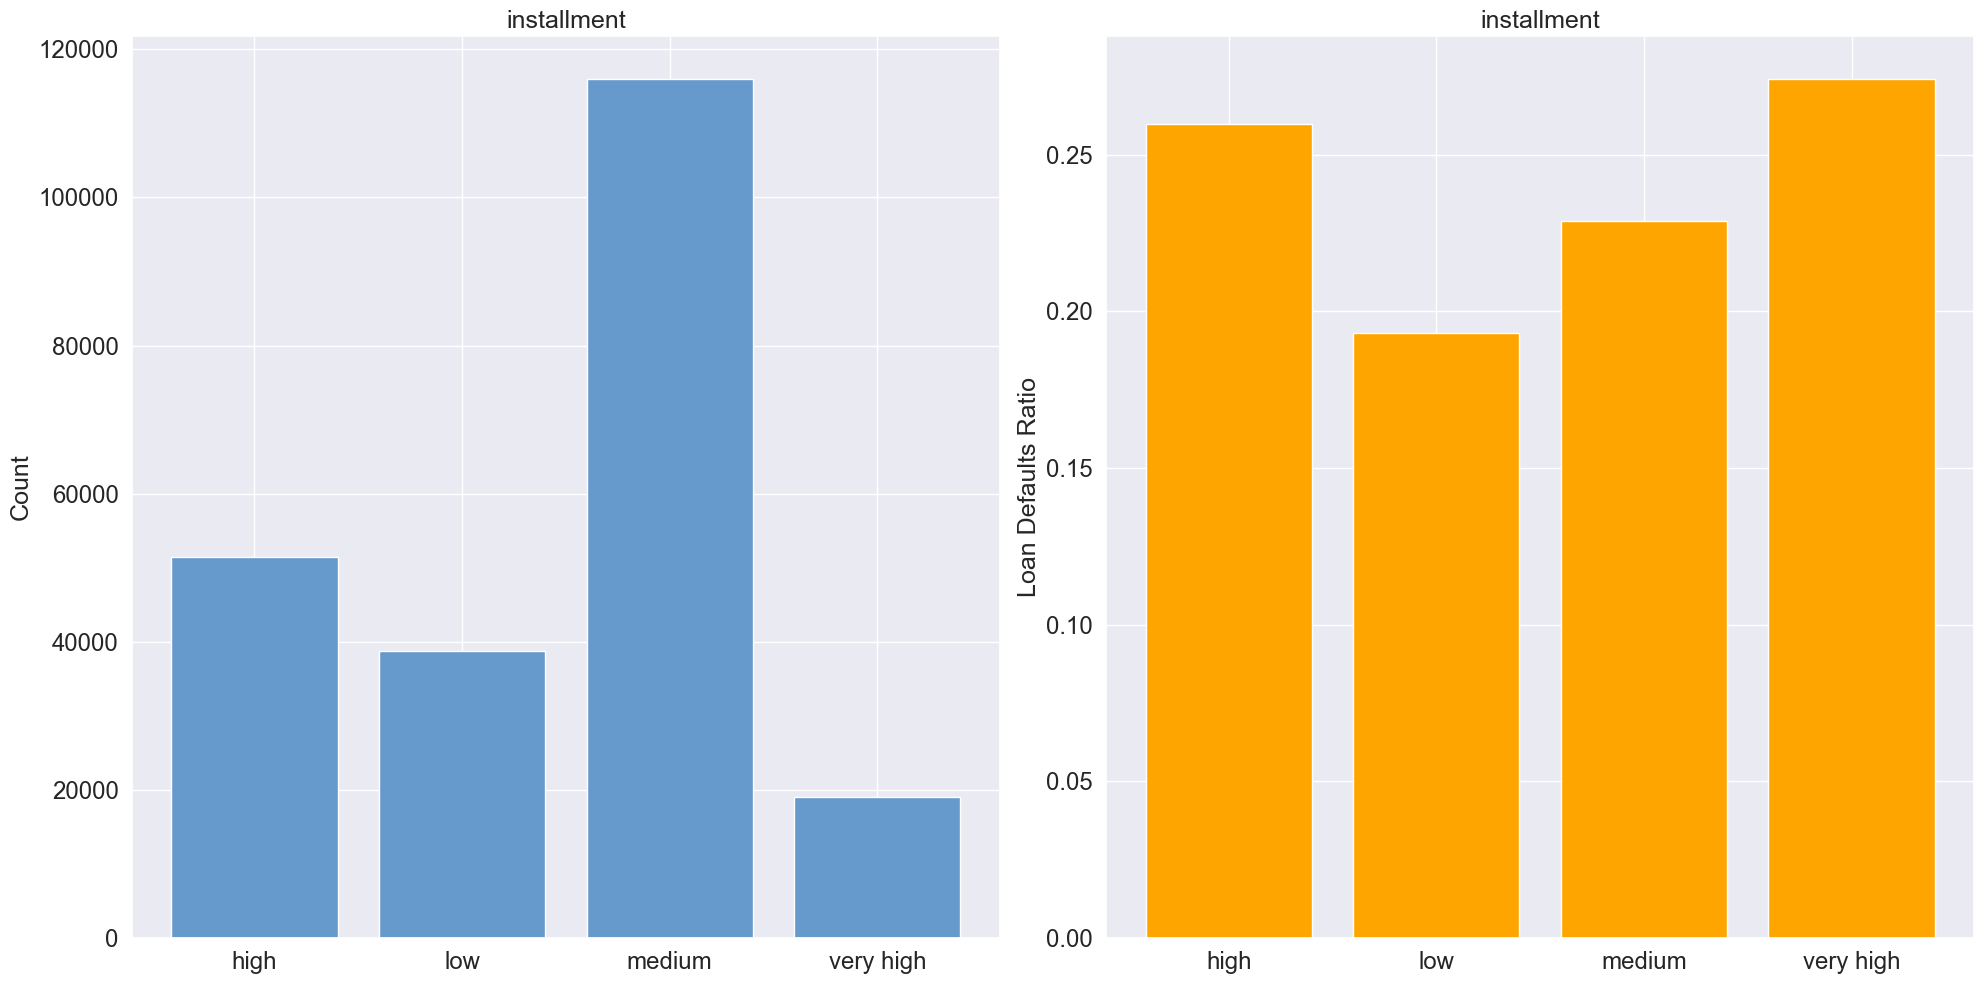

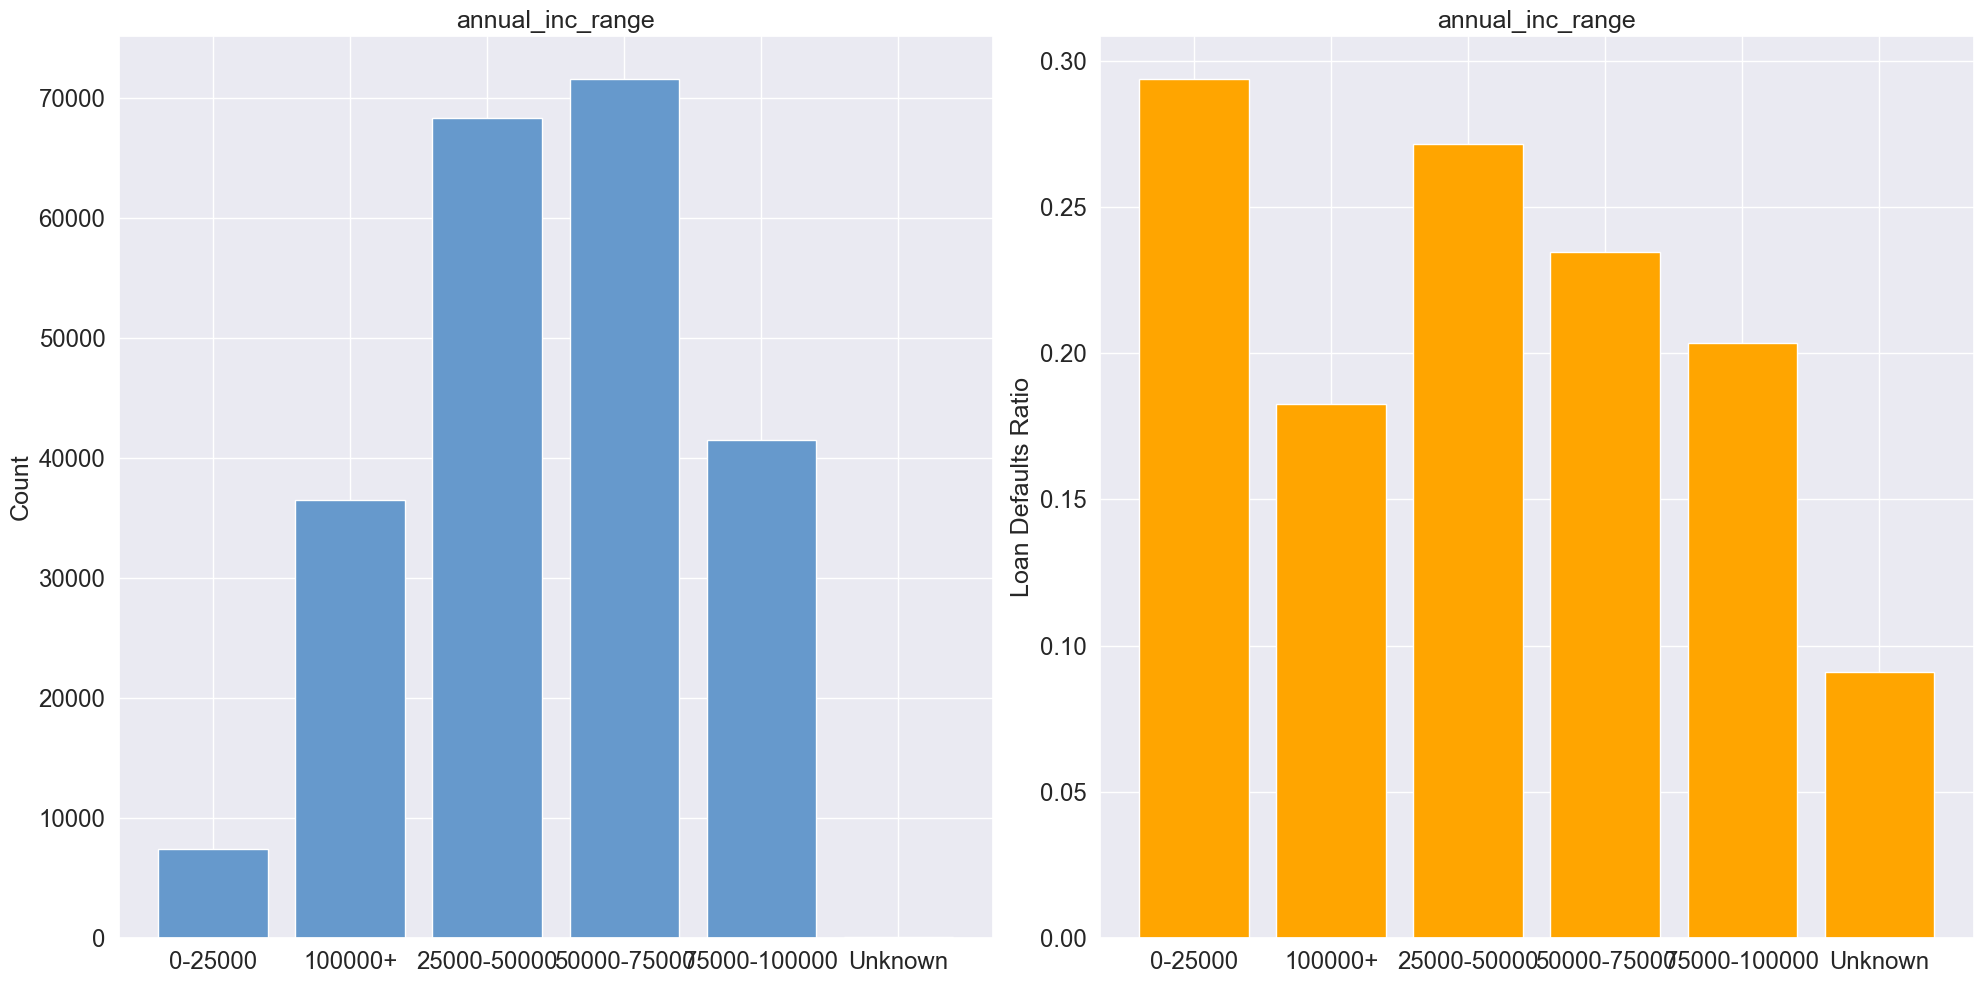

In [24]:
categorical_variables = ['emp_length', 'month', 'year', 'earliest_cr_line', 'inq_last_6mths',
                         'revol_util', 'total_acc', 'loan_amnt_range', 'int_rate_range',
                         'dti_range', 'installment', 'annual_inc_range']
plot_loan_default_ratio(df_processed, loan_status_col='loan_status', columns=categorical_variables)

Select rows with `loan_status` **`Charged Off`**, **`Current`** and **`Fully Paid`**.

In [25]:
#selected_statuses = ['Charged Off', 'Current', 'Fully Paid']
#df = df[df['loan_status'].isin(selected_statuses)]
#plot_loan_status(df)

### Loan Purpose Overview

In [26]:
#loans_purpose = df.groupby(['purpose'])['funded_amnt_inv'].sum().reset_index()
#plt.figure(figsize=(14, 10))
#plt.pie(loans_purpose["funded_amnt_inv"],labels=loans_purpose["purpose"],autopct='%1.1f%%')
#plt.title('Loan Purpose Aggregate Information')
#plt.axis('equal')
#plt.legend(loans_purpose['purpose'],title="Loan purpose",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
#plt.show()
